# 1. Data preparation

In [3]:
# sentiment
categories = ['nostalgia', 'not nostalgia']

In [4]:
# download data from web

import pandas as pd
df = pd.read_csv("hf://datasets/Senem/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data/Nostalgic_Sentiment_Analysis_of_YouTube_Comments_Data.csv")

In [8]:
# observe data
print(df)
X = df.rename(columns={'sentiment': 'sentiment_name'})

          sentiment                                            comment
0     not nostalgia  He was a singer with a golden voice that I lov...
1         nostalgia  The mist beautiful voice ever I listened to hi...
2         nostalgia  I have most of Mr. Reeves songs.  Always love ...
3     not nostalgia  30 day leave from 1st tour in Viet Nam to conv...
4         nostalgia  listening to his songs reminds me of my mum wh...
...             ...                                                ...
1495  not nostalgia  i don't know!..but the opening of the video,.....
1496  not nostalgia  it's sad this is such a beautiful song when yo...
1497  not nostalgia  Dear Friend, I think age and time is not that ...
1498      nostalgia  I was born in 1954 and started to be aware of ...
1499      nostalgia  This is the first CD I bought after my marriag...

[1500 rows x 2 columns]


In [9]:
# my functions
import helpers_homework.data_mining_helpers as dmh

# 將類別文字轉換成數字
X['sentiment'] = X['sentiment_name'].apply(lambda t: dmh.format_labels_number(t, X))
# 更換排版順序
X = X[['sentiment','comment', 'sentiment_name']]

In [10]:
X[0:10]

sentiment                                            comment sentiment_name
0          1  He was a singer with a golden voice that I lov...  not nostalgia
1          0  The mist beautiful voice ever I listened to hi...      nostalgia
2          0  I have most of Mr. Reeves songs.  Always love ...      nostalgia
3          1  30 day leave from 1st tour in Viet Nam to conv...  not nostalgia
4          0  listening to his songs reminds me of my mum wh...      nostalgia
5          0  Every time I heard this song as a child, I use...      nostalgia
6          0  My dad loved listening to Jim Reeves, when I w...      nostalgia
7          0  i HAVE ALSO LISTENED TO Jim Reeves since child...      nostalgia
8          1           Wherever you  are you always in my heart  not nostalgia
9          1  Elvis will always be number one no one can com...  not nostalgia

# 2. Data Mining

## 2.1 Missing Data processing

In [13]:
# 確認資料中有沒有遺失數值
X.isnull().apply(lambda x: dmh.check_missing_values(x))

sentiment                             comment  \
0  The amoung of missing records is:   The amoung of missing records is:    
1                                   0                                   0   

                       sentiment_name  
0  The amoung of missing records is:   
1                                   0

資料中沒有遺失數值，不用進行處理

## 2.2 Dealing with Duplicate Data

In [14]:
# 確認有無重複資料
sum(X.duplicated())

1

In [17]:
# 找尋重複資料
X[X.duplicated(keep=False)]

sentiment                                            comment  \
62          1  never heard this song before... WOW What an am...   
78          1  never heard this song before... WOW What an am...   

   sentiment_name  
62  not nostalgia  
78  not nostalgia

In [18]:
X.drop_duplicates(keep='first', inplace=True) #刪除重複的行，保留第一次出現的
X.reset_index(drop=True, inplace=True) # 從新排列索引

In [20]:
# 重新打印確認
X

sentiment                                            comment  \
0             1  He was a singer with a golden voice that I lov...   
1             0  The mist beautiful voice ever I listened to hi...   
2             0  I have most of Mr. Reeves songs.  Always love ...   
3             1  30 day leave from 1st tour in Viet Nam to conv...   
4             0  listening to his songs reminds me of my mum wh...   
...         ...                                                ...   
1494          1  i don't know!..but the opening of the video,.....   
1495          1  it's sad this is such a beautiful song when yo...   
1496          1  Dear Friend, I think age and time is not that ...   
1497          0  I was born in 1954 and started to be aware of ...   
1498          0  This is the first CD I bought after my marriag...   

     sentiment_name  
0     not nostalgia  
1         nostalgia  
2         nostalgia  
3     not nostalgia  
4         nostalgia  
...             ...  
1494  not nostalgia  
1495  not nostalgia  
1496  not nostalgia  
1497      nostalgia  
1498      nostalgia  

[1499 rows x 3 columns]

# 3. Data processing

## 3.1 Sampling

In [21]:
X_sample = X.sample(n = 750) # random state

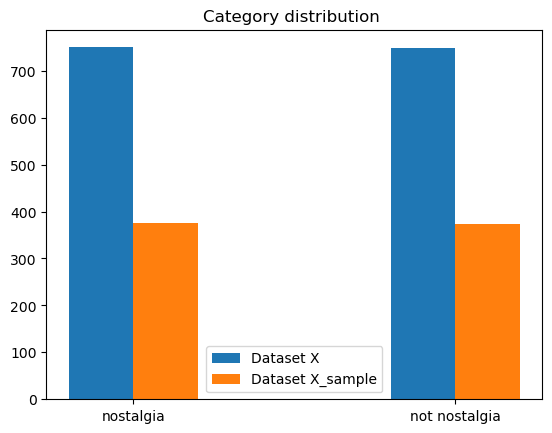

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# 計算兩個 dataset 的類別統計
X_counts = X.sentiment_name.value_counts()
X_sample_counts = X_sample.sentiment_name.value_counts()

# 找到所有的類別，並確保兩組資料對齊
all_categories = X_counts.index

# 設定 bar 寬度和位置
bar_width = 0.2
index = range(len(all_categories))

# 繪製第一組資料的柱狀圖
plt.bar(index, X_counts, bar_width, label='Dataset X')

# 繪製第二組資料的柱狀圖，並將其向右偏移
plt.bar([i + bar_width for i in index], X_sample_counts, bar_width, label='Dataset X_sample')

# 設定標題和標籤
plt.title('Category distribution ')
plt.xticks([i + bar_width / 2 for i in index],all_categories, rotation=0)

# 添加圖例
plt.legend()

# 顯示圖表
plt.show()

可以看見兩個類別的分布是 1:1 ，在整體的會分懷舊少一筆主要原因是因為有重複的資料進行了移除

## 3.2 Feature Creation

In [23]:
import nltk

In [24]:
# takes a like a minute or two to process
X['unigrams'] = X['comment'].apply(lambda x: dmh.tokenize_text(x))

## 3.3 CountVectorizer

### 3.3.1 Feature subset selection

In [395]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X.comment)
feature_terms = count_vect.get_feature_names_out()
tdm_df = pd.DataFrame(X_counts.toarray(), columns=feature_terms, index=X.index) 

In [28]:
X_counts.shape # document=1499, feature=3730

(1499, 3730)

In [44]:
# 進行目前特徵的矩陣做一些觀察
plot_x = ["term_"+str(i) for i in feature_terms[0:20]]
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]
plot_z = X_counts[0:20, 0:20].toarray() # X_counts[how many documents, how many terms]

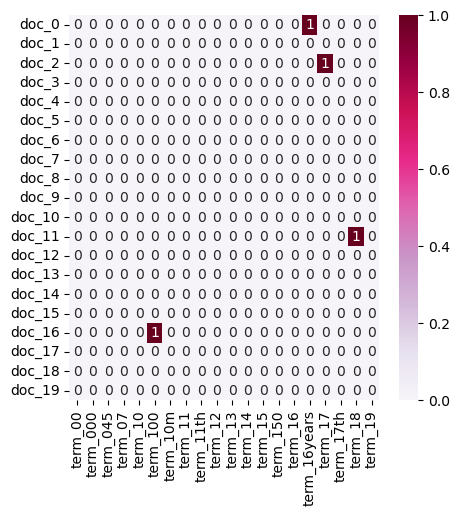

In [45]:
# 使用熱圖觀察
import seaborn as sns

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(5, 5))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd", #熱圖的顏色映射為粉紅色調
                 vmin=0, vmax=1, annot=True) #annot 熱圖的每個格子中顯示數據值
plt.show()

可以看見前20個特徵在前20個文檔的出現度很低

### 3.3.2 Attribute Transformation

In [46]:
# 找出所有特徵出現的頻率
import numpy as np
term_frequencies = []
term_frequencies = np.asarray(X_counts.sum(axis=0))[0] # 列的方向進行計算

In [50]:
term_frequencies # 所有特徵出現的次數
feature_terms # 所有特徵名字

array(['00', '000', '045', ..., 'yup', 'zealand', 'zulus'], dtype=object)

原始數據的觀察

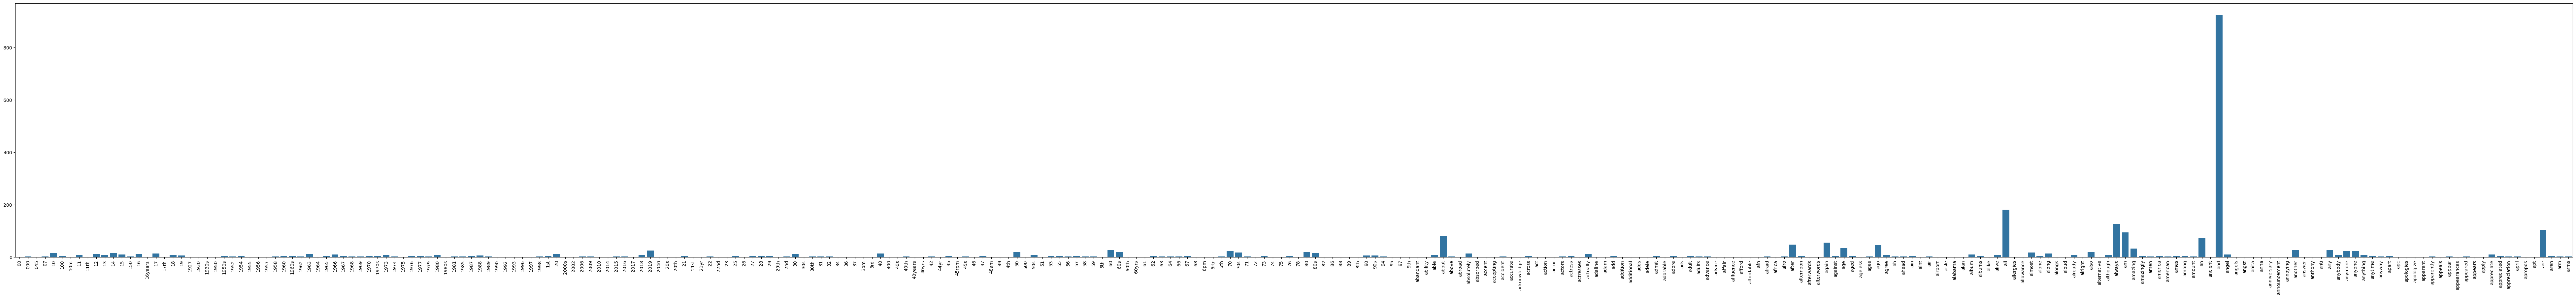

In [59]:
# 觀察前300特徵分布(原始數據)
plt.close() # 關掉先前的圖表
plt.subplots(figsize=(100, 10)) 
g = sns.barplot(x=feature_terms[:300], y=term_frequencies[:300])
g.set_xticks(range(300))  # 設置 x 軸的刻度位置
g.set_xticklabels(feature_terms[:300], rotation = 90);
plt.show()

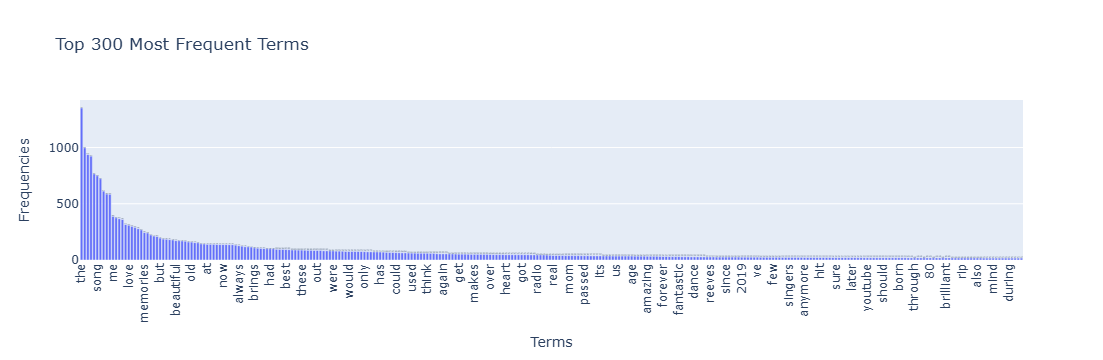

In [60]:
# 使用動態圖表觀察原始數據(由大到小前300大)
import plotly.express as px

plt.close()
data = pd.DataFrame({'Terms': feature_terms, 'Frequencies': term_frequencies})
top_data = data.nlargest(300, 'Frequencies').sort_values(by='Frequencies', ascending=False) # 選擇出現次數前50高的
fig = px.bar(top_data, x='Terms', y='Frequencies', title='Top 300 Most Frequent Terms', text='Frequencies')
fig.update_traces(texttemplate='%{text}', textposition='outside') 
fig.update_layout(xaxis_tickangle=-90)
fig.show()

原始數據取log的觀察

In [58]:
# calculate log data frequency
import math
term_frequencies_log = [math.log(i) for i in term_frequencies]

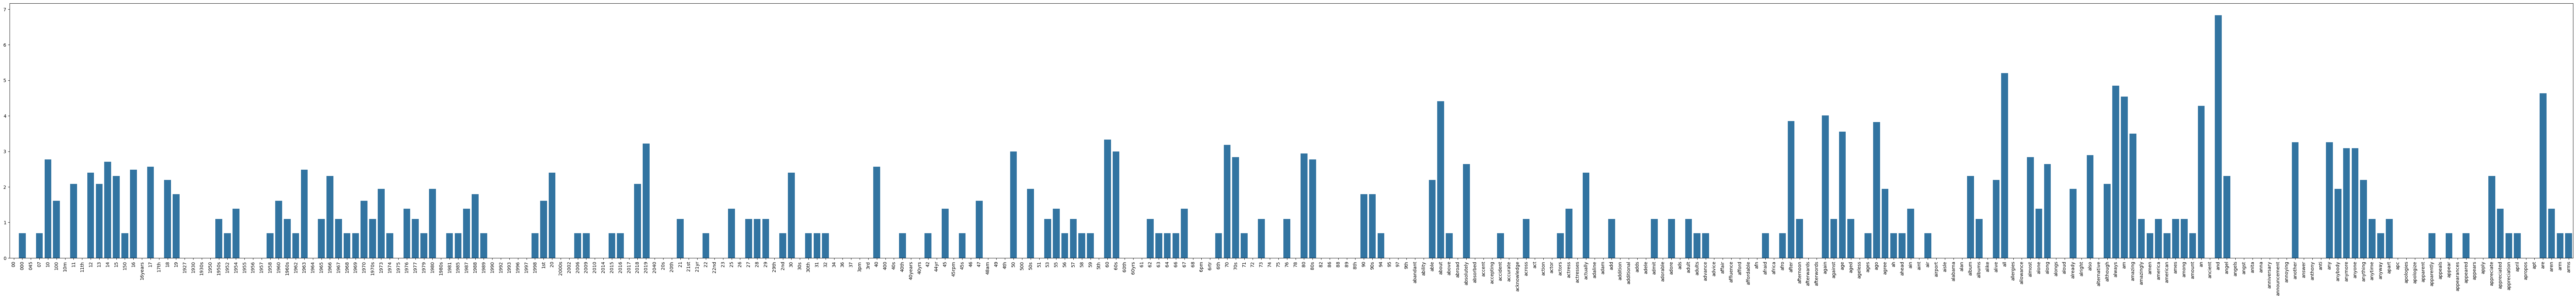

In [64]:
# 觀察前300分布(log數據)
plt.close() # 關掉先前的圖表
plt.subplots(figsize=(100, 10)) 
g = sns.barplot(x=feature_terms[:300], y=term_frequencies_log[:300])
g.set_xticks(range(300))  # 設置 x 軸的刻度位置
g.set_xticklabels(feature_terms[:300], rotation = 90);
plt.show()

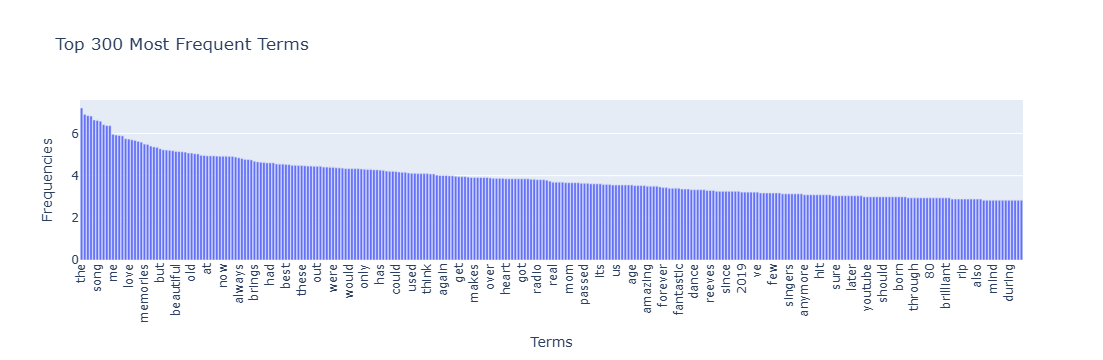

In [63]:
# 使用動態圖表觀察log數據(由大到小前300大)
import plotly.express as px

plt.close()
data = pd.DataFrame({'Terms': feature_terms, 'Frequencies': term_frequencies_log})
top_data = data.nlargest(300, 'Frequencies').sort_values(by='Frequencies', ascending=False) # 選擇出現次數前50高的
fig = px.bar(top_data, x='Terms', y='Frequencies', title='Top 300 Most Frequent Terms', text='Frequencies')
fig.update_traces(texttemplate='%{text}', textposition='outside') 
fig.update_layout(xaxis_tickangle=-90)
fig.show()

### 3.3.3 Attribute Aggregation

#### 找出各類別的原始特徵

In [71]:
category_numbers = [0,1]
category_dfs = {} 
for category in categories:
    category_dfs[category] = X[X['sentiment_name'] == category].copy()

In [181]:
# 定義生成稀疏陣列的方程式
def create_term_document_df_CountVector(df,min_df=0.0,max_df=1.0):
    count_vect_temp = CountVectorizer(min_df=min_df, max_df=max_df) # Initialize the CountVectorizer
    X_counts_temp = count_vect_temp.fit_transform(df['comment'])  # Transform the text data into word counts
    words_temp = count_vect_temp.get_feature_names_out()
    term_document_df_temp = pd.DataFrame(X_counts_temp.toarray(), columns=words_temp)
    return term_document_df_temp

In [182]:
# 分別對兩個類別找屬於他們的特徵
filt_term_document_dfs = {} 
for category in categories:
    filt_term_document_dfs[category] = create_term_document_df_CountVector(category_dfs[category])

In [183]:
# 顯示稀疏陣列
for category in categories:
    print(f"Filtered Term-Document Frequency DataFrame for Category {category}:")
    print(filt_term_document_dfs[category])

Filtered Term-Document Frequency DataFrame for Category nostalgia:
     07  10  11  11th  12  13  14  15  16  17  ...  young  younger  youngster  \
0     0   0   0     0   0   0   0   0   0   0  ...      0        0          0   
1     0   0   0     0   0   0   0   0   0   1  ...      0        0          0   
2     0   0   0     0   0   0   0   0   0   0  ...      0        0          0   
3     0   0   0     0   0   0   0   0   0   0  ...      0        0          0   
4     0   0   0     0   0   0   0   0   0   0  ...      0        0          0   
..   ..  ..  ..   ...  ..  ..  ..  ..  ..  ..  ...    ...      ...        ...   
745   0   0   0     0   0   0   0   0   0   0  ...      0        0          0   
746   0   0   0     0   0   0   0   0   0   0  ...      0        0          0   
747   0   0   0     0   0   1   0   0   0   0  ...      0        0          0   
748   0   0   0     0   0   0   0   0   0   0  ...      0        0          0   
749   0   0   0     0   0   0   0   0   0 

可以知道 nostalgia 最初有 2295 特徵；not nostalgia 有 2602 特徵

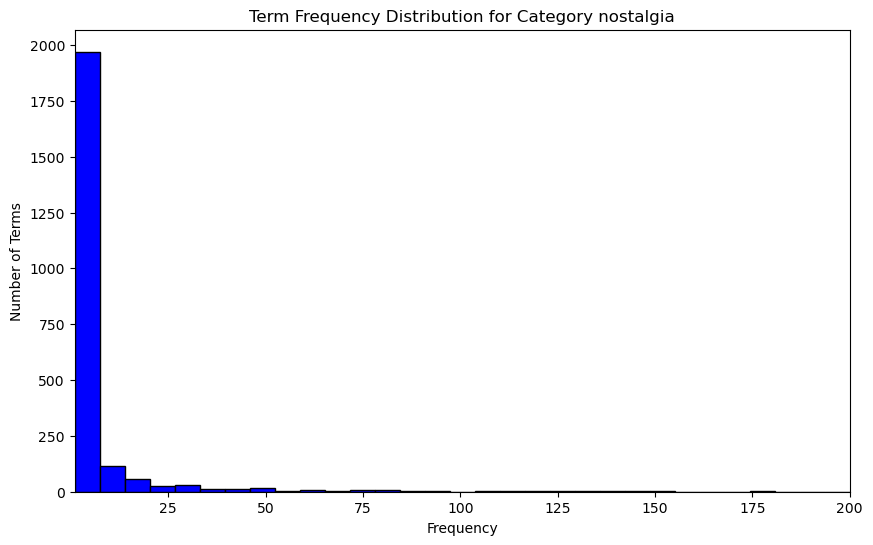

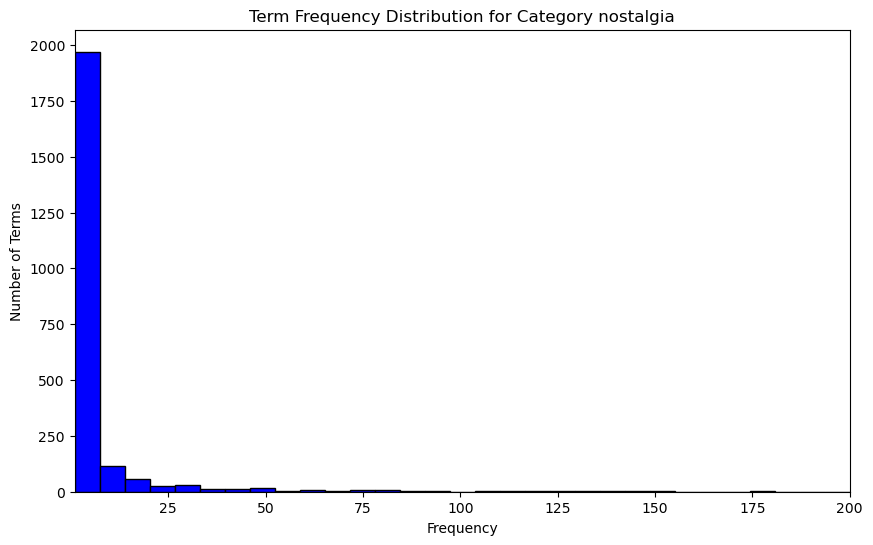

In [102]:
for category in categories:
    word_counts = filt_term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=100,color='blue', edgecolor='black')
    plt.title(f'Term Frequency Distribution for Category {categories[category_number]}')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Terms')
    plt.xlim(1, 200)
    plt.show()

在兩個類別的圖片中可以發現其實大多特徵都是僅出現比較少次，我們要排除超級少的特徵以及多到不行的

#### 刪除原始數據中過低與過高的特徵

In [104]:
# 建立刪除過小出現與過大出現次數的

def filter_top_bottom_words_by_sum(term_document_df, top_percent=0.05, bottom_percent=0.01):

    word_sums = term_document_df.sum(axis=0)
    sorted_words = word_sums.sort_values()
    
    total_words = len(sorted_words)
    top_n = int(top_percent * total_words) #過濾掉頻率高的數值
    bottom_n = int(bottom_percent * total_words) #過濾掉頻率低的數值
    
    words_to_remove = pd.concat([sorted_words.head(bottom_n), sorted_words.tail(top_n)]).index
    # print(f'Bottom {bottom_percent*100}% words: \n{sorted_words.head(bottom_n)}') #Here we print which words correspond to the bottom percentage we filter
    # print(f'Top {top_percent*100}% words: \n{sorted_words.tail(top_n)}') #Here we print which words correspond to the top percentage we filter
    
    return term_document_df.drop(columns=words_to_remove)

In [105]:
# 進行刪除最前面與最後面
term_document_dfs = {} 

for category in categories:
    print(f'\nFor category {category} we filter the following words:')
    term_document_dfs[category] = filter_top_bottom_words_by_sum(filt_term_document_dfs[category])
    print(f"Filtered Term-Document Frequency DataFrame for Category {category}:")
    print(term_document_dfs[category])


For category nostalgia we filter the following words:
Filtered Term-Document Frequency DataFrame for Category nostalgia:
     07  10  11  11th  12  13  14  15  16  17  ...  yo  yokel  younger  \
0     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
1     0   0   0     0   0   0   0   0   0   1  ...   0      0        0   
2     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
3     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
4     0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
..   ..  ..  ..   ...  ..  ..  ..  ..  ..  ..  ...  ..    ...      ...   
745   0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
746   0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
747   0   0   0     0   0   1   0   0   0   0  ...   0      0        0   
748   0   0   0     0   0   0   0   0   0   0  ...   0      0        0   
749   0   0   0     0   0   0   0   0   0   0  ...   0      0   

經過刪除之後我們要的檔案特徵變成：2602 -> 2446 ; 2295 ->2159

In [108]:
# 將現在我要的特徵儲存進csv方便取用
from PAMI.extras.convert.DF2DB import DF2DB

for category in term_document_dfs:
    category_safe = category.replace(' ', '_')
    obj = DF2DB(term_document_dfs[category])
    obj.convert2TransactionalDatabase(f'./td_freq_db/td_freq_db_{category_safe}.csv', '>=', 1)

In [132]:
# transactional Dataset Observe
from PAMI.extras.dbStats import TransactionalDatabase as tds

def observaion_transactional_Database(name):
    plt.close()
    name = name.replace(' ', '_')
    obj = tds.TransactionalDatabase(f'./td_freq_db/td_freq_db_{name}.csv')
    print(f'Transational Dataset {name}:')
    obj.run()
    obj.printStats()
    obj.plotGraphs()
    plt.show()

Transational Dataset nostalgia:
Database size (total no of transactions) : 734
Number of items : 2159
Minimum Transaction Size : 1
Average Transaction Size : 8.693460490463215
Maximum Transaction Size : 39
Standard Deviation Transaction Size : 7.213372063492091
Variance in Transaction Sizes : 52.10372252435774
Sparsity : 0.9959733855996001


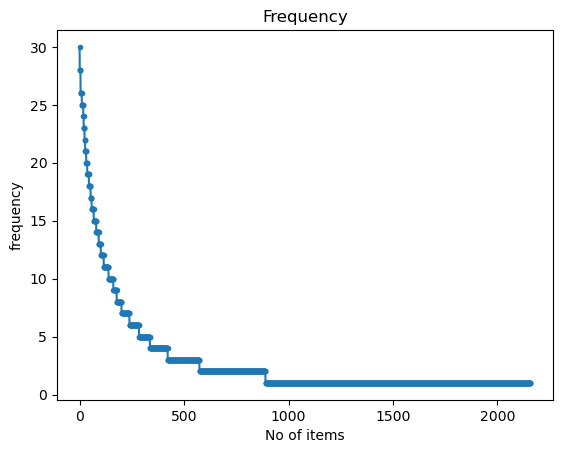

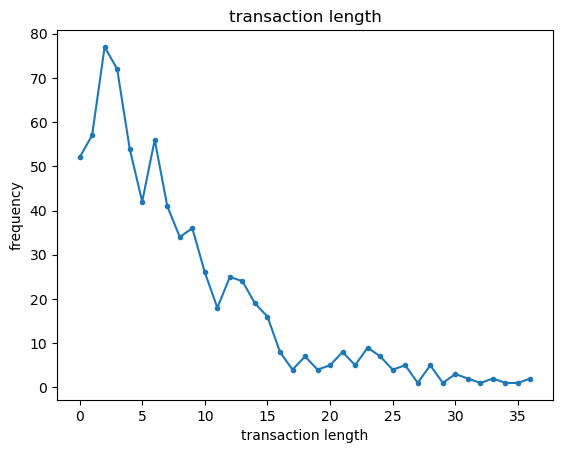

Transational Dataset not_nostalgia:
Database size (total no of transactions) : 745
Number of items : 2446
Minimum Transaction Size : 1
Average Transaction Size : 8.410738255033557
Maximum Transaction Size : 46
Standard Deviation Transaction Size : 5.926429722323316
Variance in Transaction Sizes : 35.16977700801039
Sparsity : 0.9965614316210002


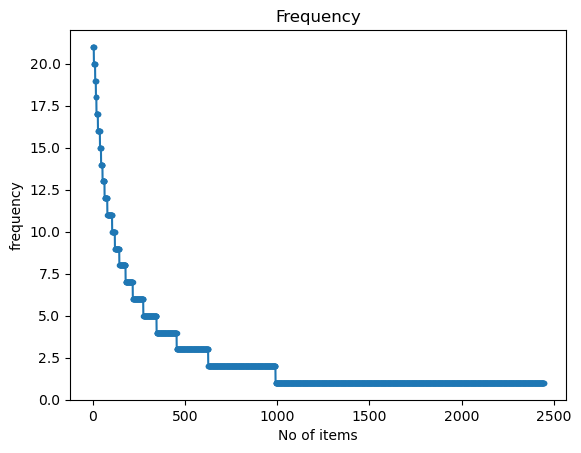

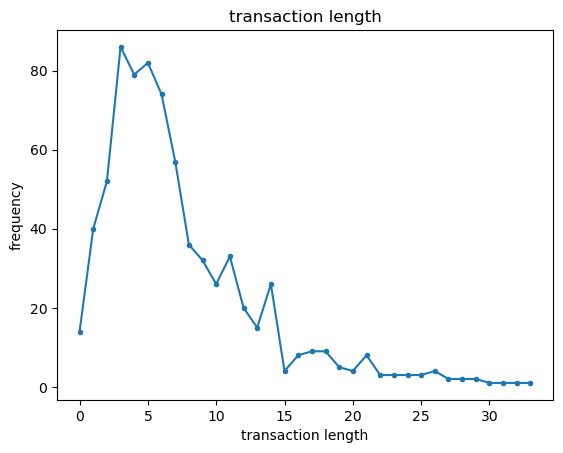

In [133]:
for category in categories:
    observaion_transactional_Database(category)

#### augmented_df 的製作 by FPGrowth, FAE topK, MaxFPGrowth

In [253]:
# use FPGrowth with minsup
from PAMI.frequentPattern.basic import FPGrowth as alg

def FPGrowth_minsup(minSup,name):
    obj = alg.FPGrowth(iFile=f'./td_freq_db/td_freq_db_{name}.csv', minSup=minSup)
    obj.mine()
    frequentPatternsDF_temp = obj.getPatternsAsDataFrame()
    print(name)
    print('Total No of patterns: ' + str(len(frequentPatternsDF_temp)))
    print('Runtime: ' + str(obj.getRuntime()))
    obj.save(f'./freq_patterns_minsup/freq_patterns_{name}_minSup{minSup}.txt') #save the patterns
    return frequentPatternsDF_temp

In [254]:
# use FAE topK
from PAMI.frequentPattern.topk import FAE
def FAE_topK(k,name):
    obj = FAE.FAE(iFile=f'./td_freq_db/td_freq_db_{name}.csv', k=k)
    obj.mine()
    frequentPatternsDF_temp = obj.getPatternsAsDataFrame()
    print(name)
    print('Total No of patterns: ' + str(len(frequentPatternsDF_temp)))
    print('Runtime: ' + str(obj.getRuntime()))
    obj.save(f'./freq_patterns_topK/freq_patterns_{name}_topK{k}.txt') #save the patterns
    return frequentPatternsDF_temp

In [255]:
# use MaxFPGrowth with minsup
from PAMI.frequentPattern.maximal import MaxFPGrowth as algm

def FPGrowth_max(minSup,name):
    obj = algm.MaxFPGrowth(iFile=f'./td_freq_db/td_freq_db_{name}.csv', minSup=minSup)
    obj.mine()
    frequentPatternsDF_temp = obj.getPatternsAsDataFrame()
    print(name)
    print('Total No of patterns: ' + str(len(frequentPatternsDF_temp)))
    print('Runtime: ' + str(obj.getRuntime()))
    obj.save(f'./freq_patterns_max/freq_patterns_{name}_max_minSup{minSup}.txt') #save the patterns
    return frequentPatternsDF_temp

In [256]:
def pattern_integrate(frequentPatternsDF):

    dfs = []
    for category in categories:
        dfs.append(frequentPatternsDF[category])
        
    combined_df = pd.concat(dfs, ignore_index=True)
    pattern_counts = combined_df['Patterns'].value_counts()
    unique_patterns = pattern_counts[pattern_counts == 1].index
    final_pattern_df = combined_df[combined_df['Patterns'].isin(unique_patterns)].sort_values(by='Support', ascending=False)
    # print(final_pattern_df) 
    # print(f"Number of patterns discarded: {(len(pattern_counts) - len(unique_patterns))*2}")  # Count of discarded patterns

    return final_pattern_df

In [257]:
def augmented_df_generation(final_pattern_df):
    X['tokenized_comment'] = X['comment'].str.split().apply(set)
    pattern_matrix = pd.DataFrame(0, index=X.index, columns=final_pattern_df['Patterns'])
    
    for pattern in final_pattern_df['Patterns']:
        pattern_words = set(pattern.split())  # Tokenize pattern into words
        pattern_matrix[pattern] = X['tokenized_comment'].apply(lambda x: 1 if pattern_words.issubset(x) else 0)
        
    augmented_df = pd.concat([tdm_df, pattern_matrix], axis=1) # 結合上方找出的特徵

    return augmented_df 

In [282]:
# 使用 minsup = 3去找出模型訓練的特徵

frequentPatternsDF_minsup = {}

for category in categories:
    category_save = category.replace(' ', '_')
    frequentPatternsDF_minsup[category] = FPGrowth_minsup(3,category_save)
    print (frequentPatternsDF_minsup[category])
    
final_pattern_df_minsup = pattern_integrate(frequentPatternsDF_minsup)
augmented_df_minsup = augmented_df_generation(final_pattern_df_minsup)
augmented_df_minsup

Frequent patterns were generated successfully using frequentPatternGrowth algorithm
nostalgia
Total No of patterns: 948
Runtime: 0.03229928016662598
          Patterns  Support
0           forgot        3
1               mr        3
2       appreciate        3
3            death        3
4        death jim        3
..             ...      ...
943          would       28
944           will       28
945  will favorite        3
946             go       28
947       favorite       30

[948 rows x 2 columns]
Frequent patterns were generated successfully using frequentPatternGrowth algorithm
not_nostalgia
Total No of patterns: 730
Runtime: 0.03779029846191406
         Patterns  Support
0       emotional        3
1             fan        3
2              30        3
3        blessing        3
4        december        3
..            ...      ...
725       classic       21
726          them       21
727    them every        4
728        lyrics       21
729  lyrics every        3

[730 rows x 2

00  000  045  07  10  100  10m  11  11th  12  ...  later year  \
0      0    0    0   0   0    0    0   0     0   0  ...           0   
1      0    0    0   0   0    0    0   0     0   0  ...           0   
2      0    0    0   0   0    0    0   0     0   0  ...           0   
3      0    0    0   0   0    0    0   0     0   0  ...           0   
4      0    0    0   0   0    0    0   0     0   0  ...           0   
...   ..  ...  ...  ..  ..  ...  ...  ..   ...  ..  ...         ...   
1494   0    0    0   0   0    0    0   0     0   0  ...           0   
1495   0    0    0   0   0    0    0   0     0   0  ...           0   
1496   0    0    0   0   0    0    0   0     0   0  ...           0   
1497   0    0    0   0   0    0    0   0     0   0  ...           0   
1498   0    0    0   0   0    0    0   0     0   0  ...           0   

      later been  later ever  make cry  make them  make where  hearing away  \
0              0           0         0          0           0             0   
1              0           0         0          0           0             0   
2              0           0         0          0           0             0   
3              0           0         0          0           0             0   
4              0           0         0          0           0             0   
...          ...         ...       ...        ...         ...           ...   
1494           0           0         0          0           0             0   
1495           0           0         0          0           0             0   
1496           0           0         0          0           0             0   
1497           0           0         0          0           0             0   
1498           0           0         0          0           0             0   

      missed today  country over  lyrics every  
0                0             0             0  
1                0             0             0  
2                0             0             0  
3                0             0             0  
4                0             0             0  
...            ...           ...           ...  
1494             0             0             0  
1495             0             0             0  
1496             0             0             0  
1497             0             0             0  
1498             0             0             0  

[1499 rows x 4784 columns]

In [283]:
# 使用 FAE_topK k=800 去找出模型訓練的特徵

frequentPatternsDF_topK = {}

for category in categories:
    category_save = category.replace(' ', '_')
    frequentPatternsDF_topK[category] = FAE_topK(800,category_save)
    print (frequentPatternsDF_topK[category])
    
final_pattern_df_topK = pattern_integrate(frequentPatternsDF_topK)
augmented_df_topK = augmented_df_generation(final_pattern_df_topK)
augmented_df_topK

 TopK frequent patterns were successfully generated using FAE algorithm.
nostalgia
Total No of patterns: 800
Runtime: 0.4227485656738281
         Patterns  Support
0        favorite       30
1            ever       28
2           would       28
3            will       28
4              go       28
..            ...      ...
795      over get        3
796  over country        3
797    over which        3
798      over pop        3
799  over perfect        3

[800 rows x 2 columns]
 TopK frequent patterns were successfully generated using FAE algorithm.
not_nostalgia
Total No of patterns: 800
Runtime: 0.23230886459350586
       Patterns  Support
0         elvis       21
1         every       21
2         loved       21
3       classic       21
4          them       21
..          ...      ...
795  difference        2
796        nine        2
797        slap        2
798     naughty        2
799       needs        2

[800 rows x 2 columns]


00  000  045  07  10  100  10m  11  11th  12  ...  fall  describes  \
0      0    0    0   0   0    0    0   0     0   0  ...     0          0   
1      0    0    0   0   0    0    0   0     0   0  ...     0          0   
2      0    0    0   0   0    0    0   0     0   0  ...     0          0   
3      0    0    0   0   0    0    0   0     0   0  ...     0          0   
4      0    0    0   0   0    0    0   0     0   0  ...     0          0   
...   ..  ...  ...  ..  ..  ...  ...  ..   ...  ..  ...   ...        ...   
1494   0    0    0   0   0    0    0   0     0   0  ...     0          0   
1495   0    0    0   0   0    0    0   0     0   0  ...     0          0   
1496   0    0    0   0   0    0    0   0     0   0  ...     0          0   
1497   0    0    0   0   0    0    0   0     0   0  ...     0          0   
1498   0    0    0   0   0    0    0   0     0   0  ...     0          0   

      compose  memorable  genre  amazingly  sweetest  arms  cruel  needs  
0           0          0      0          0         0     0      0      0  
1           0          0      0          0         0     0      0      0  
2           0          0      0          0         0     0      0      0  
3           0          0      0          0         0     0      0      0  
4           0          0      0          0         0     0      0      0  
...       ...        ...    ...        ...       ...   ...    ...    ...  
1494        0          0      0          0         0     0      0      0  
1495        0          0      0          0         0     0      0      0  
1496        0          0      0          0         0     0      0      0  
1497        0          0      0          0         0     0      0      0  
1498        0          0      0          0         0     0      0      0  

[1499 rows x 4700 columns]

In [284]:
# 使用 MaxFPGrowth minsup = 3 去找出模型訓練的特徵

frequentPatternsDF_max = {}

for category in categories:
    category_save = category.replace(' ', '_')
    frequentPatternsDF_max[category] = FPGrowth_max(3,category_save)
    print (frequentPatternsDF_max[category])
    
final_pattern_df_max = pattern_integrate(frequentPatternsDF_max)
augmented_df_max = augmented_df_generation(final_pattern_df_max)
augmented_df_max

Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
nostalgia
Total No of patterns: 682
Runtime: 0.03145194053649902
           Patterns  Support
0          skating         3
1           walker         3
2            scott         3
3          17 1987         3
4             stop         3
..              ...      ...
677      will such         4
678      ever only         3
679     would only         4
680       ever kid         3
681  favorite will         3

[682 rows x 2 columns]
Maximal Frequent patterns were generated successfully using MaxFp-Growth algorithm 
not_nostalgia
Total No of patterns: 592
Runtime: 0.03683590888977051
          Patterns  Support
0          thinks         3
1          months         3
2       currently         3
3            kids         3
4            wait         3
..             ...      ...
587          days        20
588  every lyrics         3
589    every them         4
590       classic        21
591         loved 

00  000  045  07  10  100  10m  11  11th  12  ...  wish could see   \
0      0    0    0   0   0    0    0   0     0   0  ...                0   
1      0    0    0   0   0    0    0   0     0   0  ...                0   
2      0    0    0   0   0    0    0   0     0   0  ...                0   
3      0    0    0   0   0    0    0   0     0   0  ...                0   
4      0    0    0   0   0    0    0   0     0   0  ...                0   
...   ..  ...  ...  ..  ..  ...  ...  ..   ...  ..  ...              ...   
1494   0    0    0   0   0    0    0   0     0   0  ...                0   
1495   0    0    0   0   0    0    0   0     0   0  ...                0   
1496   0    0    0   0   0    0    0   0     0   0  ...                0   
1497   0    0    0   0   0    0    0   0     0   0  ...                0   
1498   0    0    0   0   0    0    0   0     0   0  ...                0   

      ever boy   us too   been too   about too   listened singer   no singer   \
0             0        0          0           0                 0           0   
1             0        0          0           0                 0           0   
2             0        0          0           0                 0           0   
3             0        0          0           0                 0           0   
4             0        0          0           0                 0           0   
...         ...      ...        ...         ...               ...         ...   
1494          0        0          0           0                 0           0   
1495          0        0          0           0                 0           0   
1496          0        0          0           0                 0           0   
1497          0        0          0           0                 0           0   
1498          0        0          0           0                 0           0   

      well singer   since singer   since got   
0                0              0           0  
1                0              0           0  
2                0              0           0  
3                0              0           0  
4                0              0           0  
...            ...            ...         ...  
1494             0              0           0  
1495             0              0           0  
1496             0              0           0  
1497             0              0           0  
1498             0              0           0  

[1499 rows x 4710 columns]

### 3.3.4 Dimensionality Reduction

#### 2D by PCA, t-SNE, UMAP

In [261]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [262]:
col = ['coral', 'blue']

In [263]:
def Dimensionality_2D(now_df):
    X_pca = PCA(n_components=2).fit_transform(now_df.values)
    X_tsne = TSNE(n_components=2).fit_transform(now_df.values)
    X_umap = umap.UMAP(n_components=2).fit_transform(now_df.values)
    return X_pca, X_tsne, X_umap

In [264]:
def plot_scatter(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['sentiment_name'] == category].T[0]
        ys = X_reduced[X['sentiment_name'] == category].T[1]
        ax.scatter(xs, ys, c=c, marker='o', label=category)
    
    ax.grid(color='gray', linestyle=':', linewidth=2, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend(loc='upper right')

In [265]:
def draw_2D_plt(X_pca, X_tsne, X_umap):
    plt.close()
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))  
    fig.suptitle('PCA, t-SNE, and UMAP Comparison')
    plot_scatter(axes[0], X_pca, 'PCA')
    plot_scatter(axes[1], X_tsne, 't-SNE')
    plot_scatter(axes[2], X_umap, 'UMAP')
    plt.show()

In [266]:
X_pca, X_tsne, X_umap = Dimensionality_2D(tdm_df)

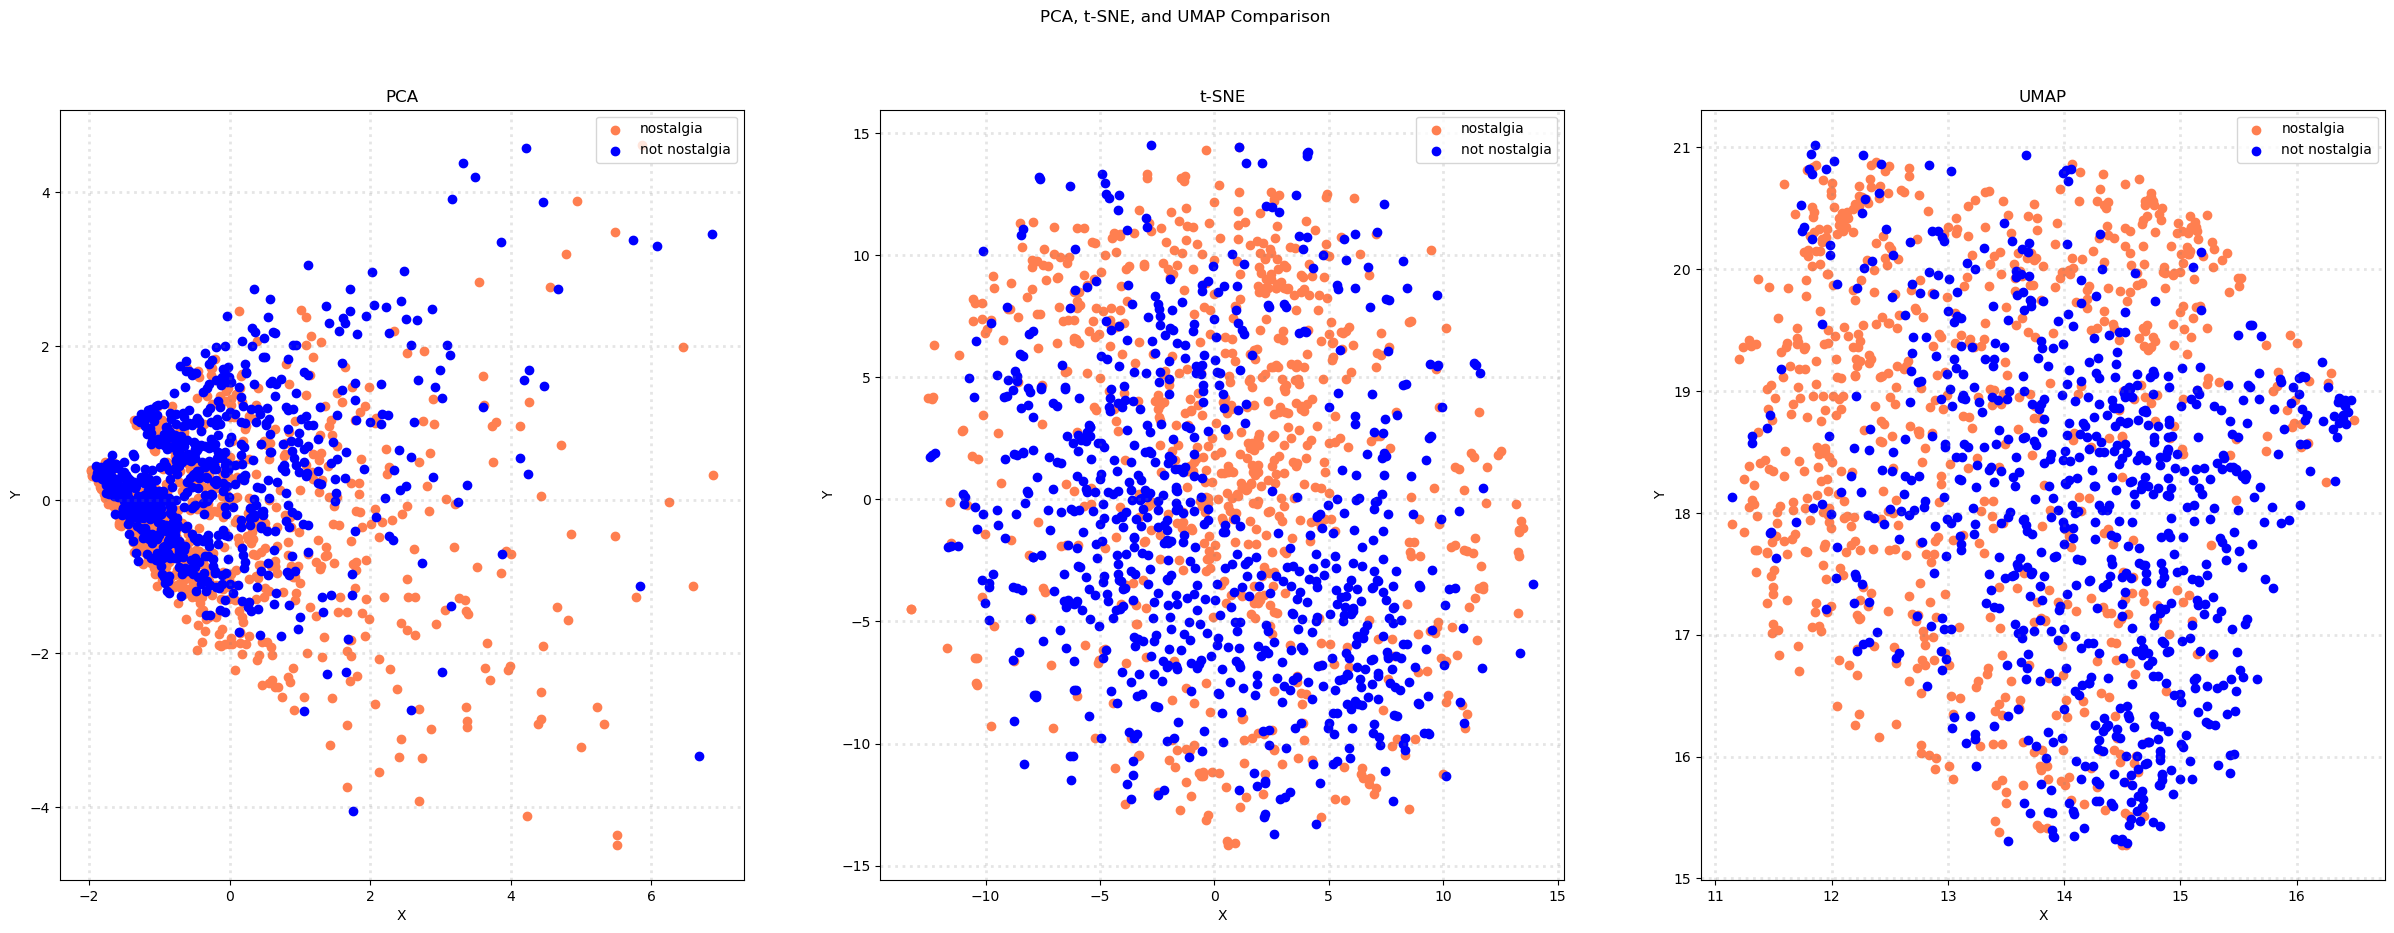

In [267]:
draw_2D_plt(X_pca, X_tsne, X_umap)

In [268]:
X_pca, X_tsne, X_umap = Dimensionality_2D(augmented_df) # minsup FPGrowth

In [269]:
X_pca.shape

(1499, 2)

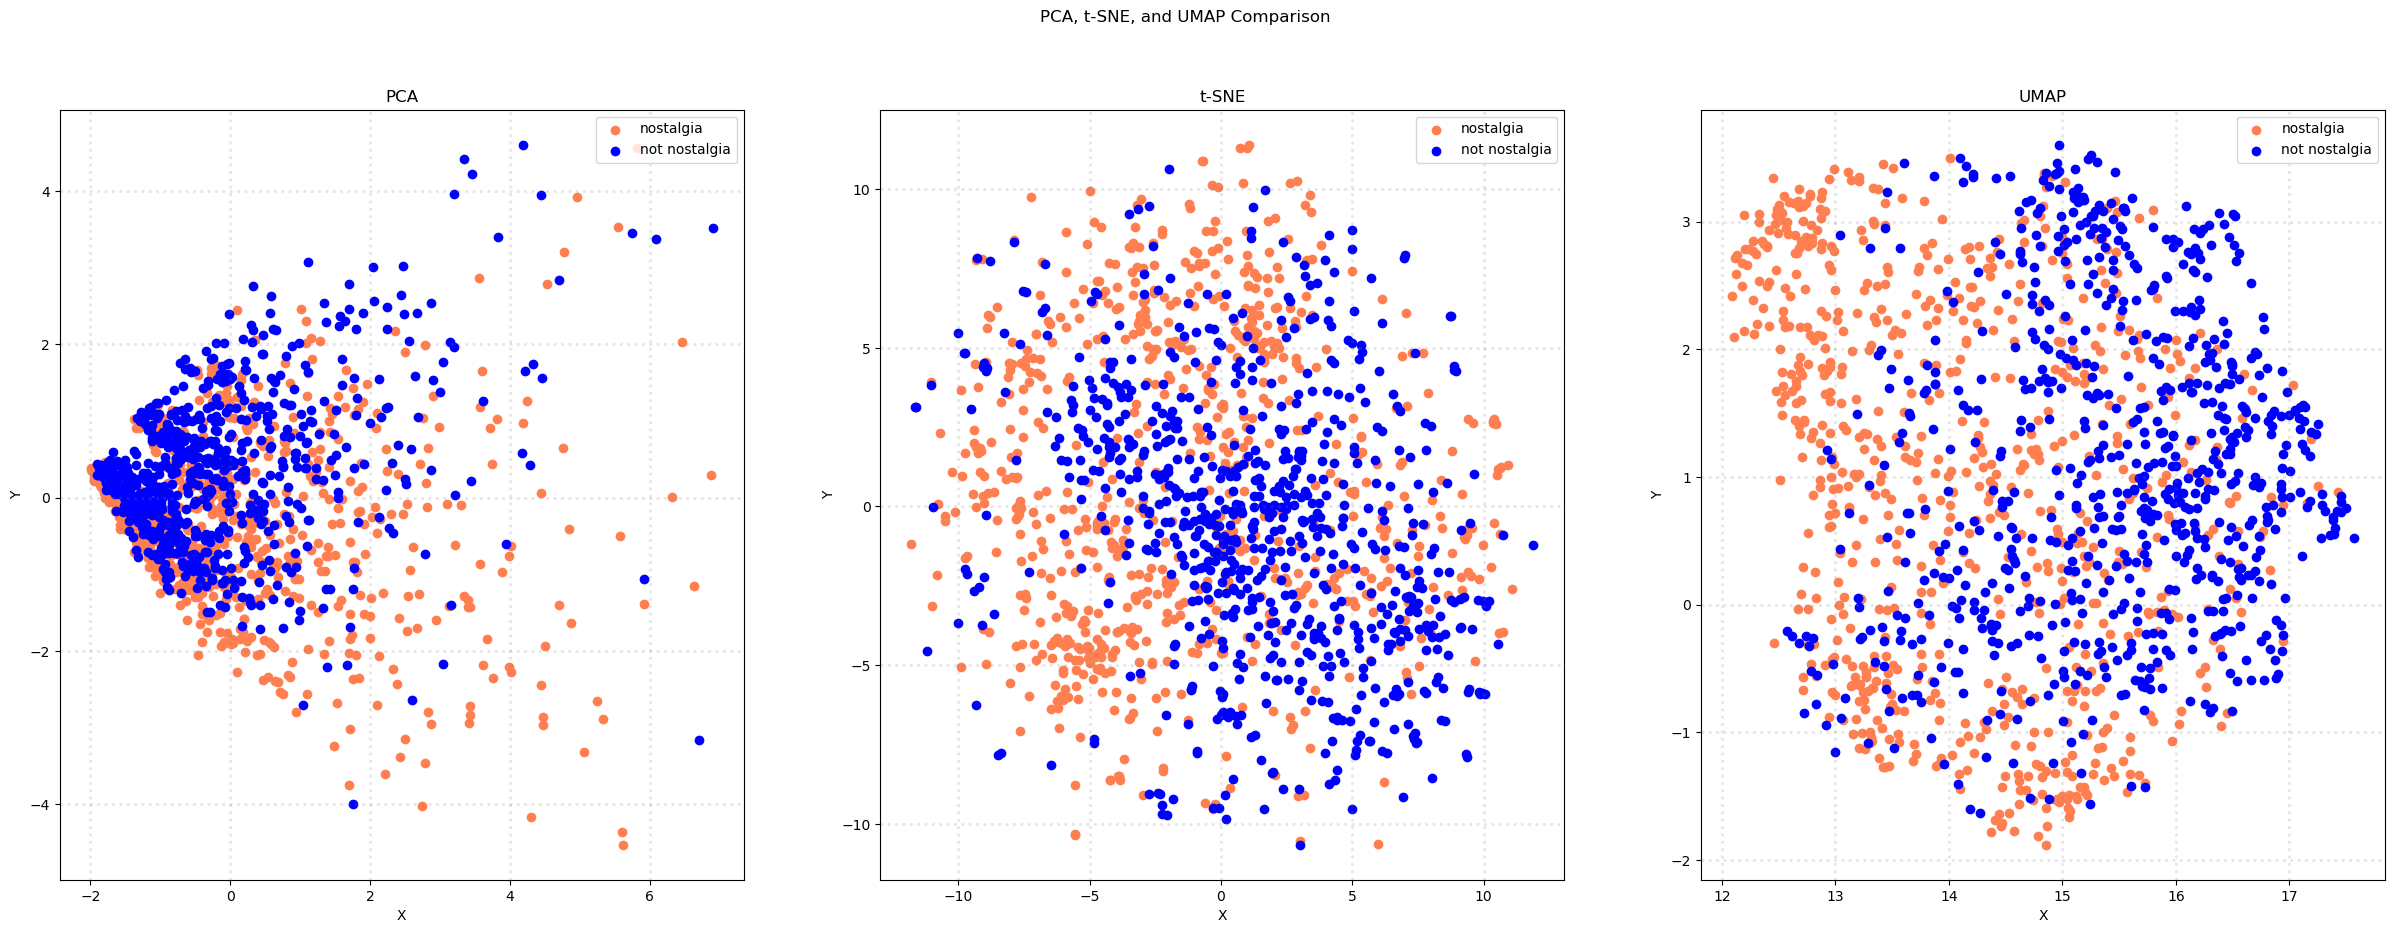

In [270]:
draw_2D_plt(X_pca, X_tsne, X_umap)

#### 3D by PCA, t-SNE, UMAP

In [271]:
from mpl_toolkits.mplot3d import Axes3D

In [272]:
def Dimensionality_3D(now_df):
    X_pca = PCA(n_components=3).fit_transform(now_df.values)
    X_tsne = TSNE(n_components=3).fit_transform(now_df.values)
    X_umap = umap.UMAP(n_components=3).fit_transform(now_df.values)
    return X_pca, X_tsne, X_umap

In [285]:
X_pca_minsup, X_tsne_minsup, X_umap_minsup = Dimensionality_3D(augmented_df_minsup)

In [274]:
X_pca_topK, X_tsne_topK, X_umap_topK = Dimensionality_3D(augmented_df_topK)

In [275]:
X_pca_max, X_tsne_max, X_umap_max = Dimensionality_3D(augmented_df_max)

In [276]:
angle_3D = [[0, 15, 90], [0, 60, 120]]

# Define a function to create 3D scatter plot
def plot_scatter_3d(ax, X_reduced, title):
    for c, category in zip(col, categories):
        xs = X_reduced[X['sentiment_name'] == category][:, 0]
        ys = X_reduced[X['sentiment_name'] == category][:, 1]
        zs = X_reduced[X['sentiment_name'] == category][:, 2]
        ax.scatter(xs, ys, zs, c=c, marker='o', label=category)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper right')
    ax.set_title(title)

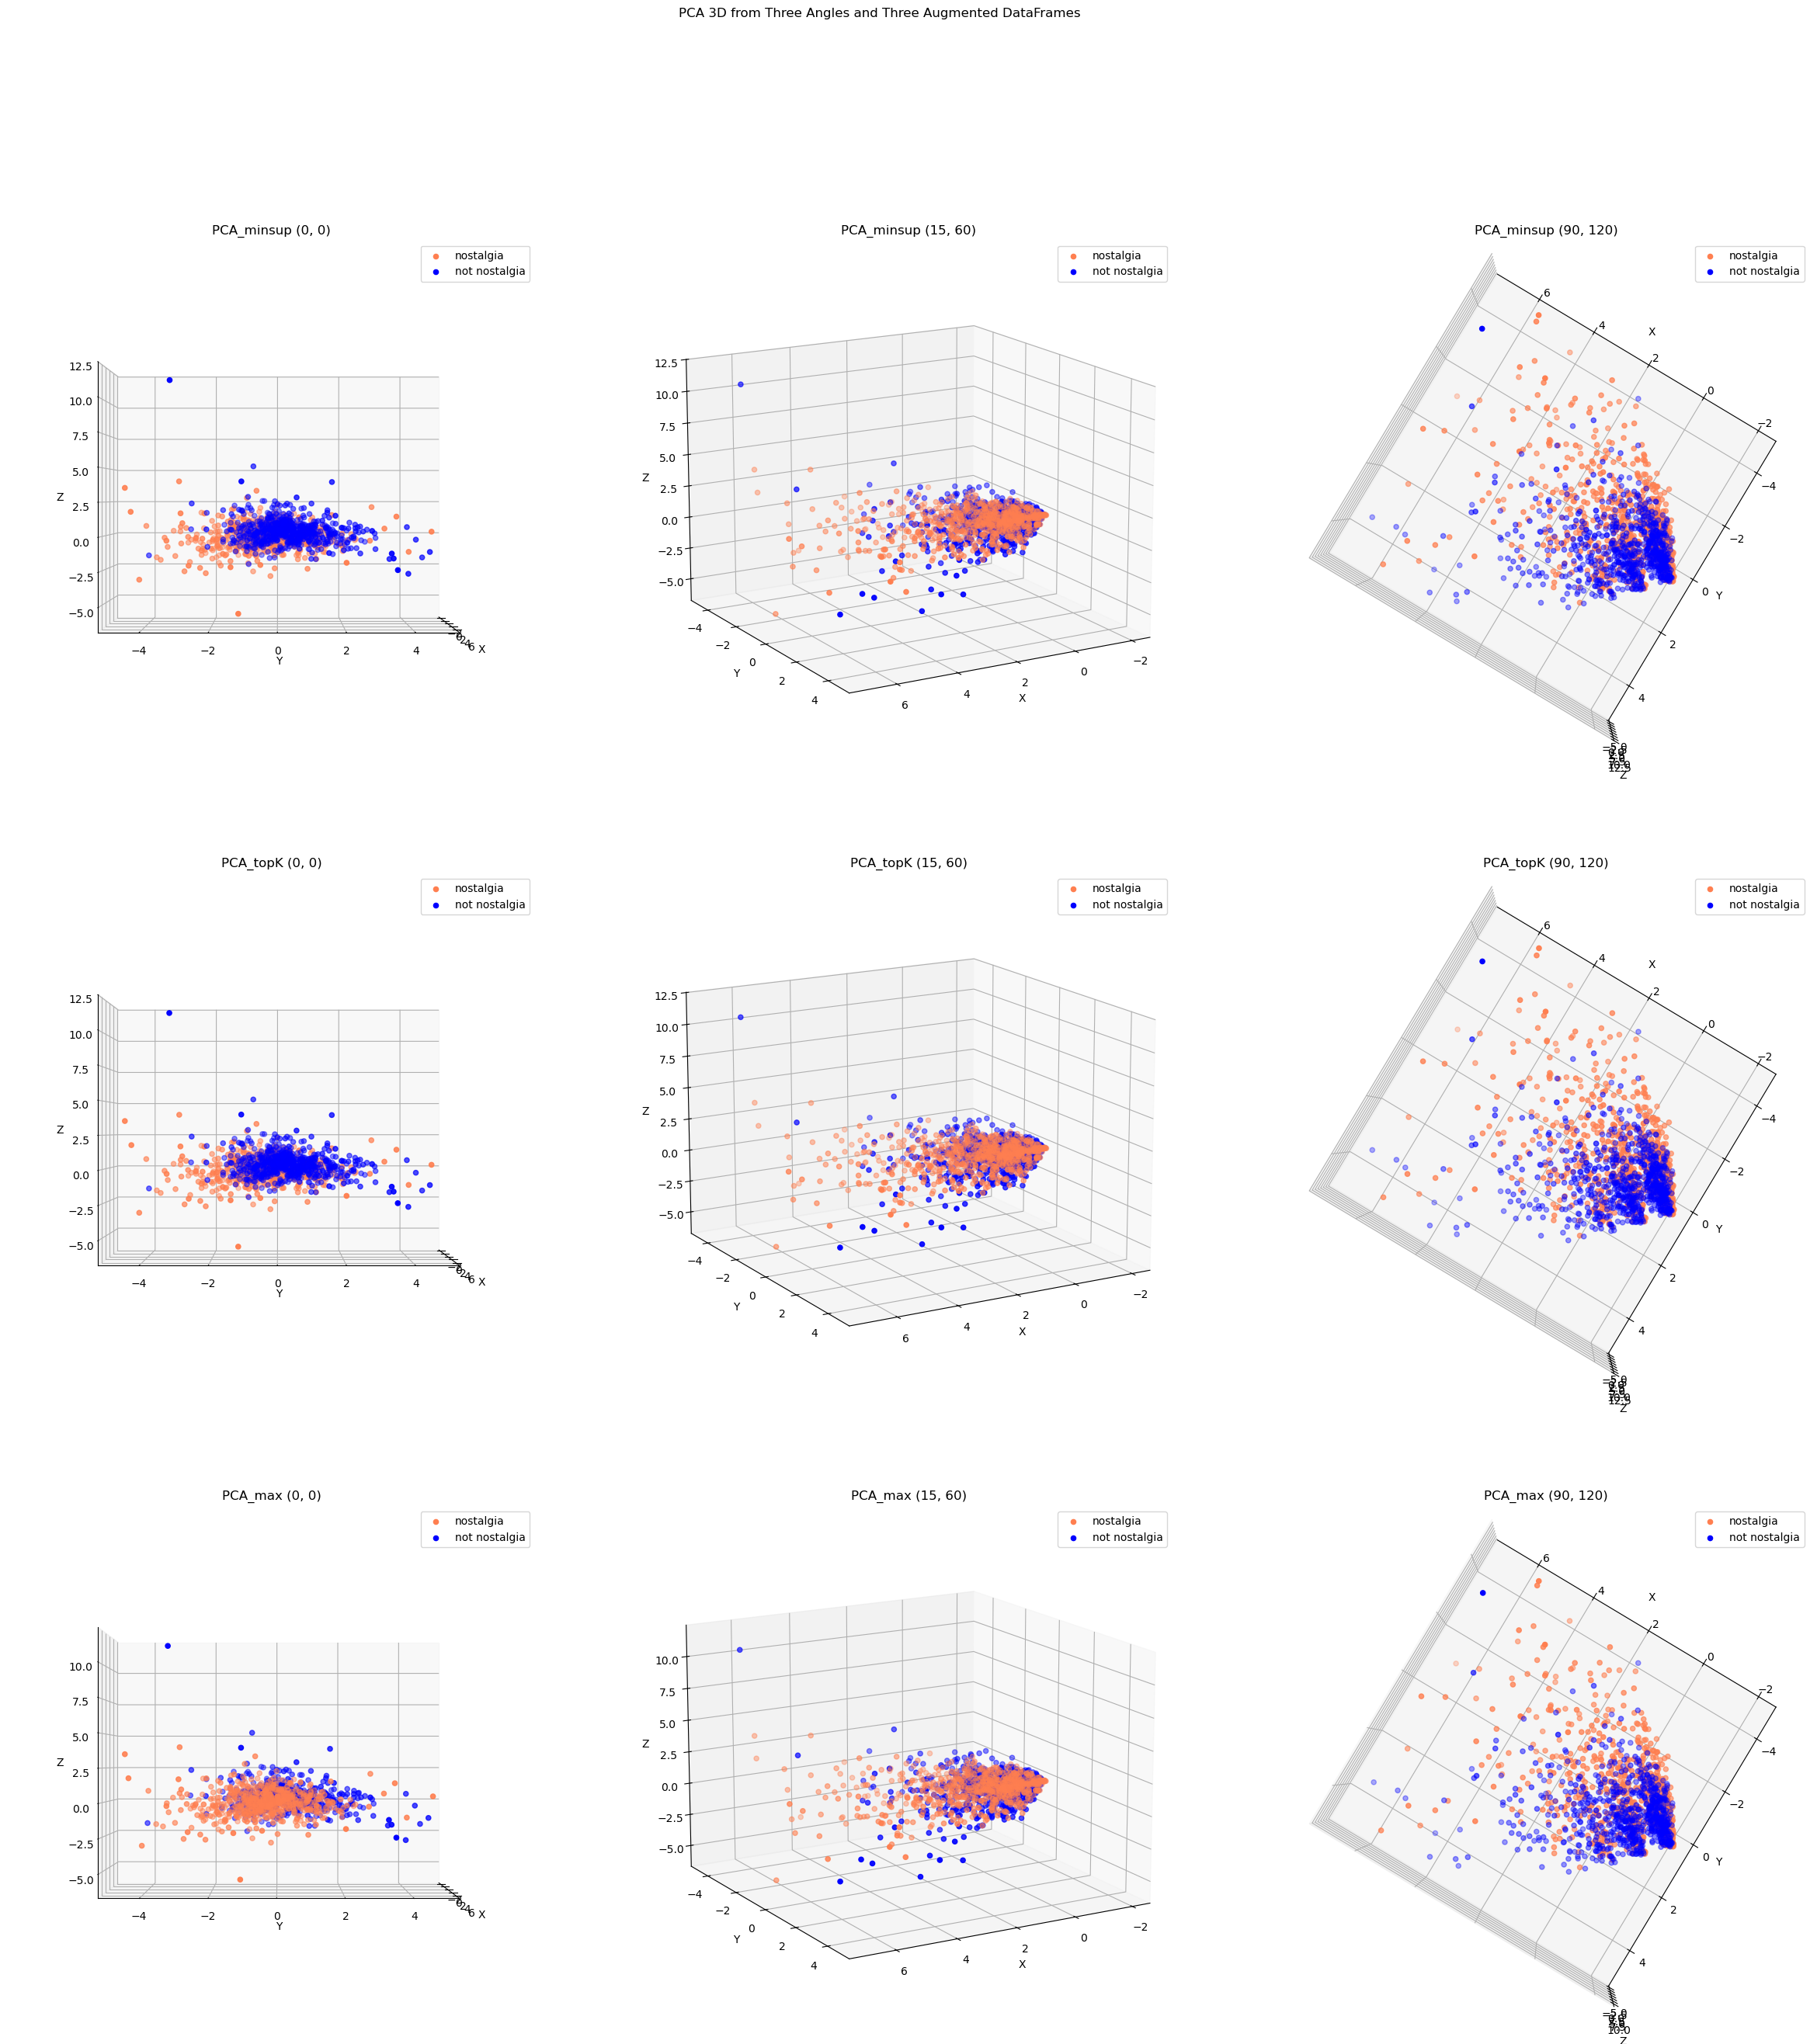

In [296]:
# 建立模型三維圖片(PCA)
plt.close()
fig = plt.figure(figsize=(30, 30))  # 創建一個大圖形以容納九個子圖
fig.suptitle('PCA 3D from Three Angles and Three Augmented DataFrames')

# 第一組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 1 + i, projection='3d')  # 3行3列
    plot_scatter_3d(ax, X_pca_minsup, f'PCA_minsup ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角

# 第二組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 4 + i, projection='3d')  # 3行3列，接下來的3個子圖
    plot_scatter_3d(ax, X_pca_topK, f'PCA_topK ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角

# 第三組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 7 + i, projection='3d')  # 3行3列，最後的3個子圖
    plot_scatter_3d(ax, X_pca_max, f'PCA_max ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角
plt.show()

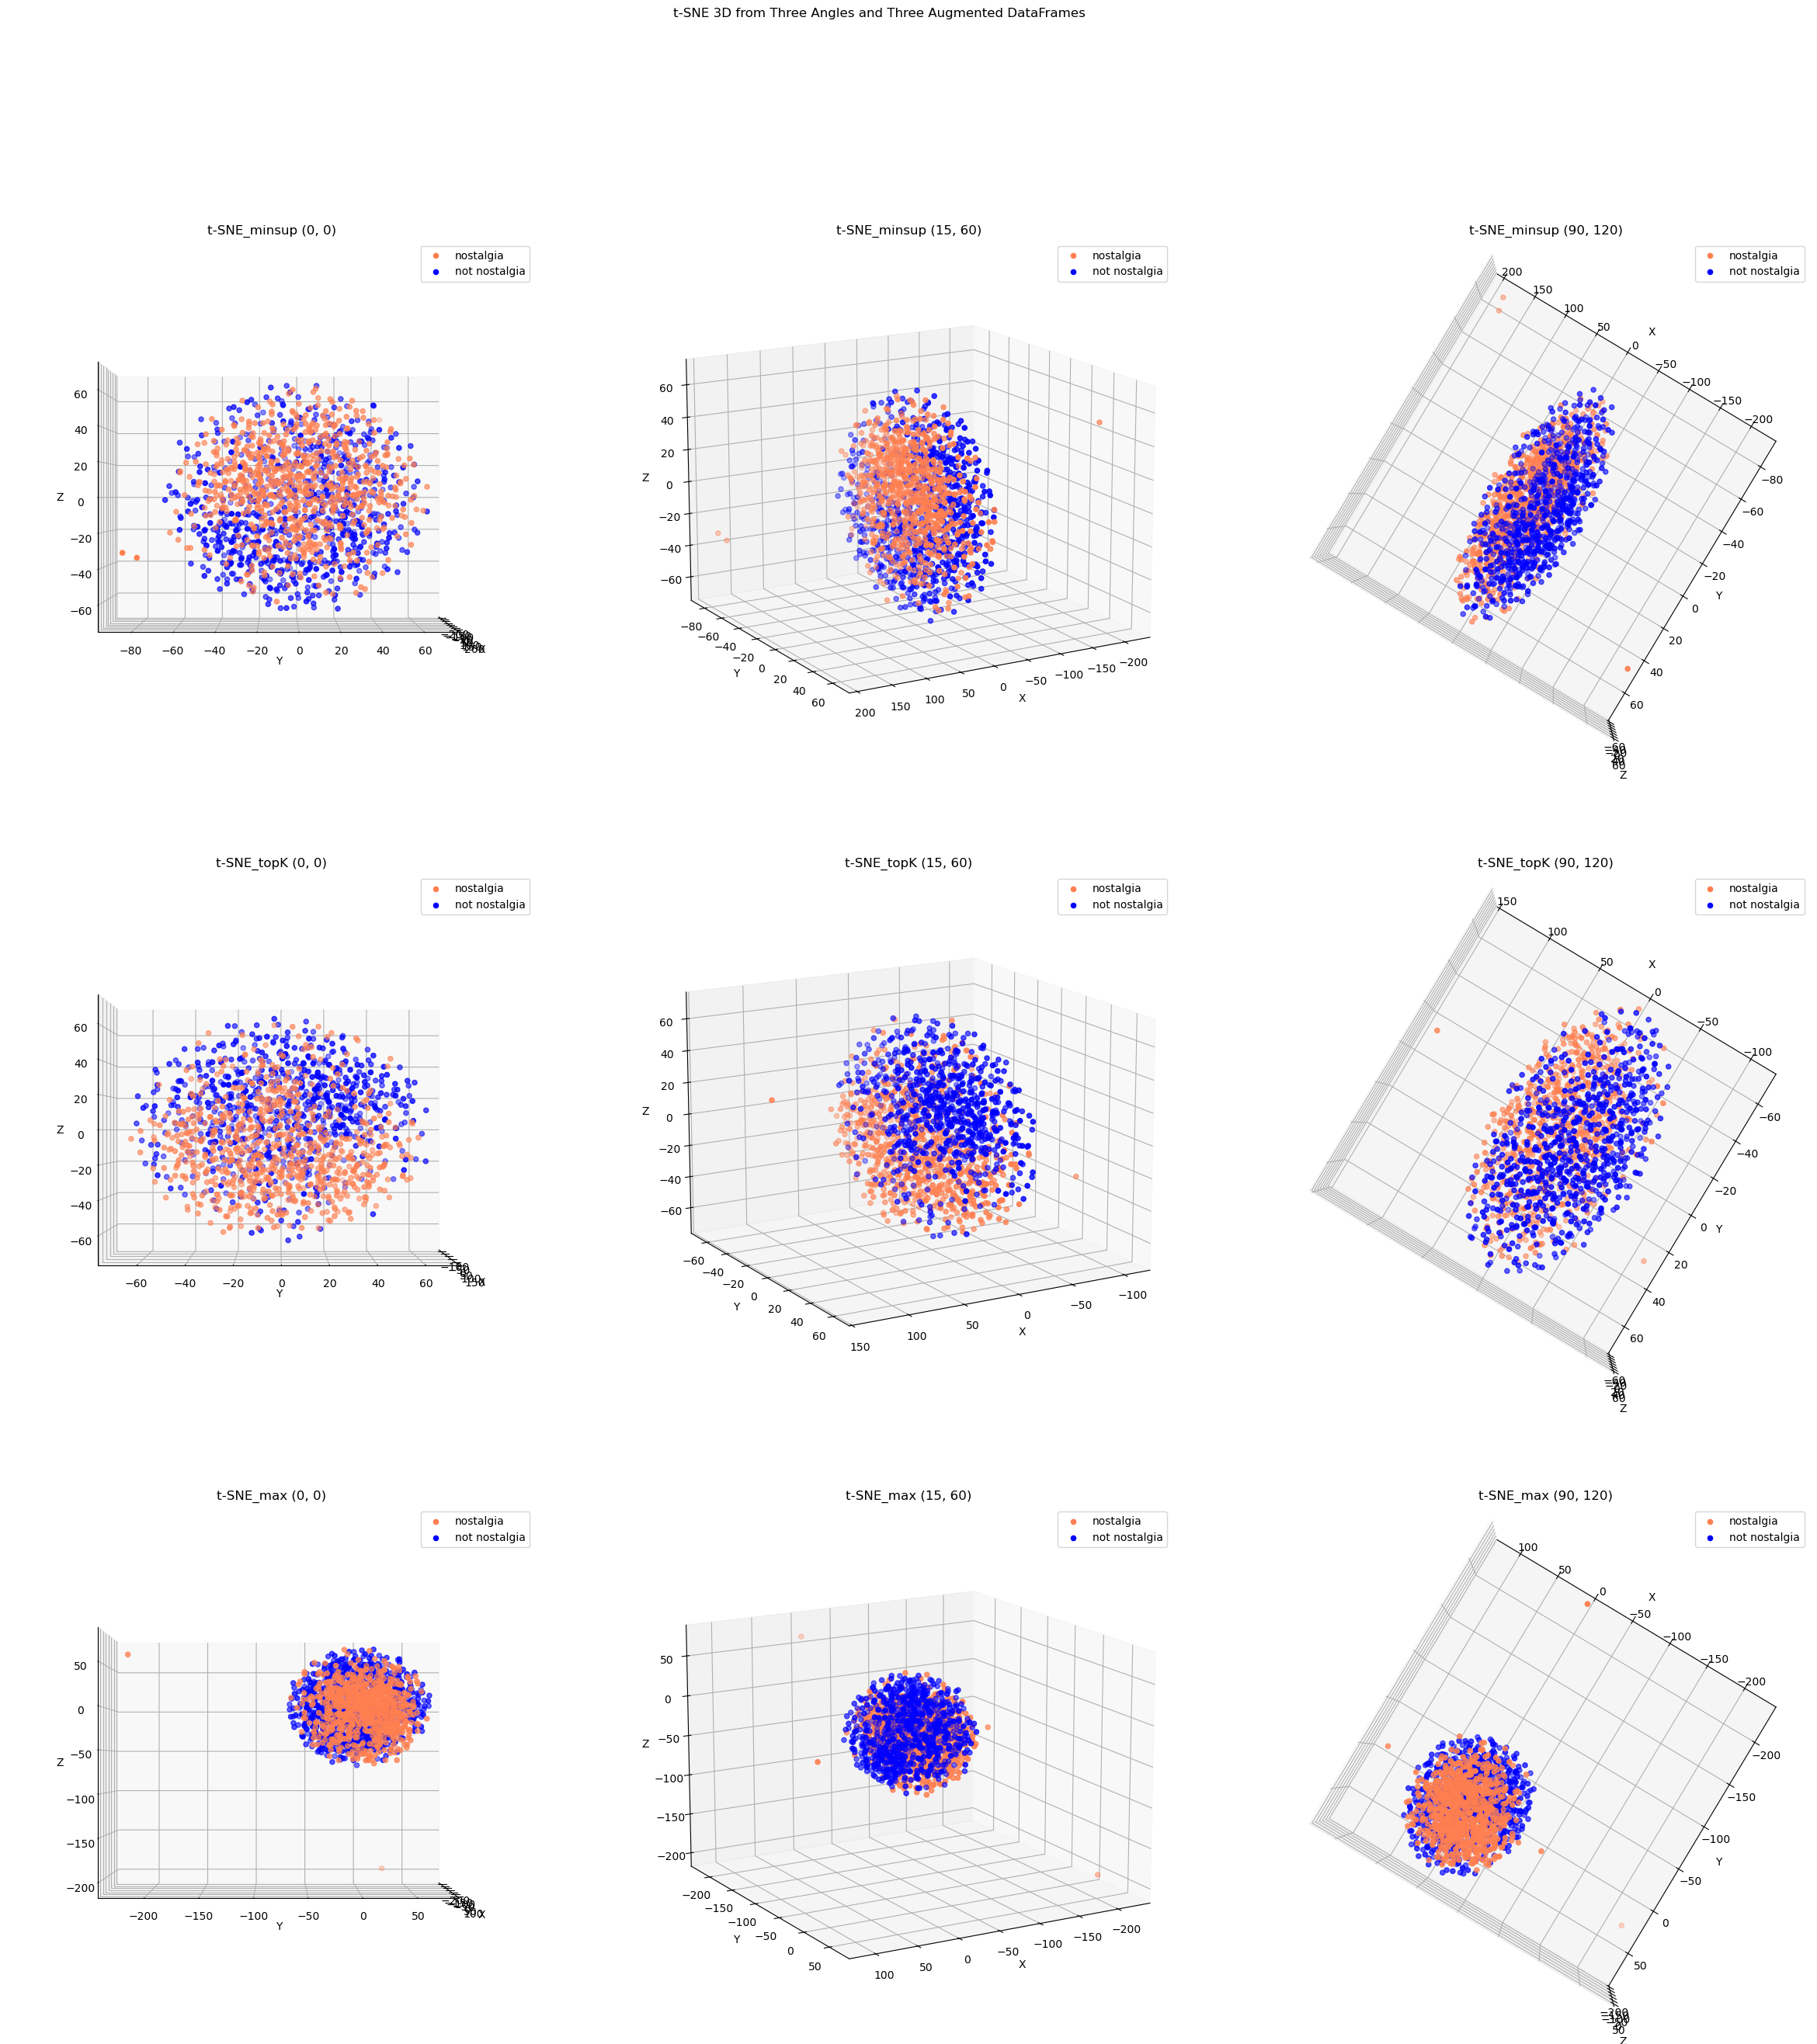

In [297]:
# 建立模型三維圖片(PCA)
plt.close()
fig = plt.figure(figsize=(30, 30))  # 創建一個大圖形以容納九個子圖
fig.suptitle('t-SNE 3D from Three Angles and Three Augmented DataFrames')

# 第一組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 1 + i, projection='3d')  # 3行3列
    plot_scatter_3d(ax, X_tsne_minsup, f't-SNE_minsup ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角

# 第二組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 4 + i, projection='3d')  # 3行3列，接下來的3個子圖
    plot_scatter_3d(ax, X_tsne_topK, f't-SNE_topK ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角

# 第三組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 7 + i, projection='3d')  # 3行3列，最後的3個子圖
    plot_scatter_3d(ax, X_tsne_max, f't-SNE_max ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角
plt.show()

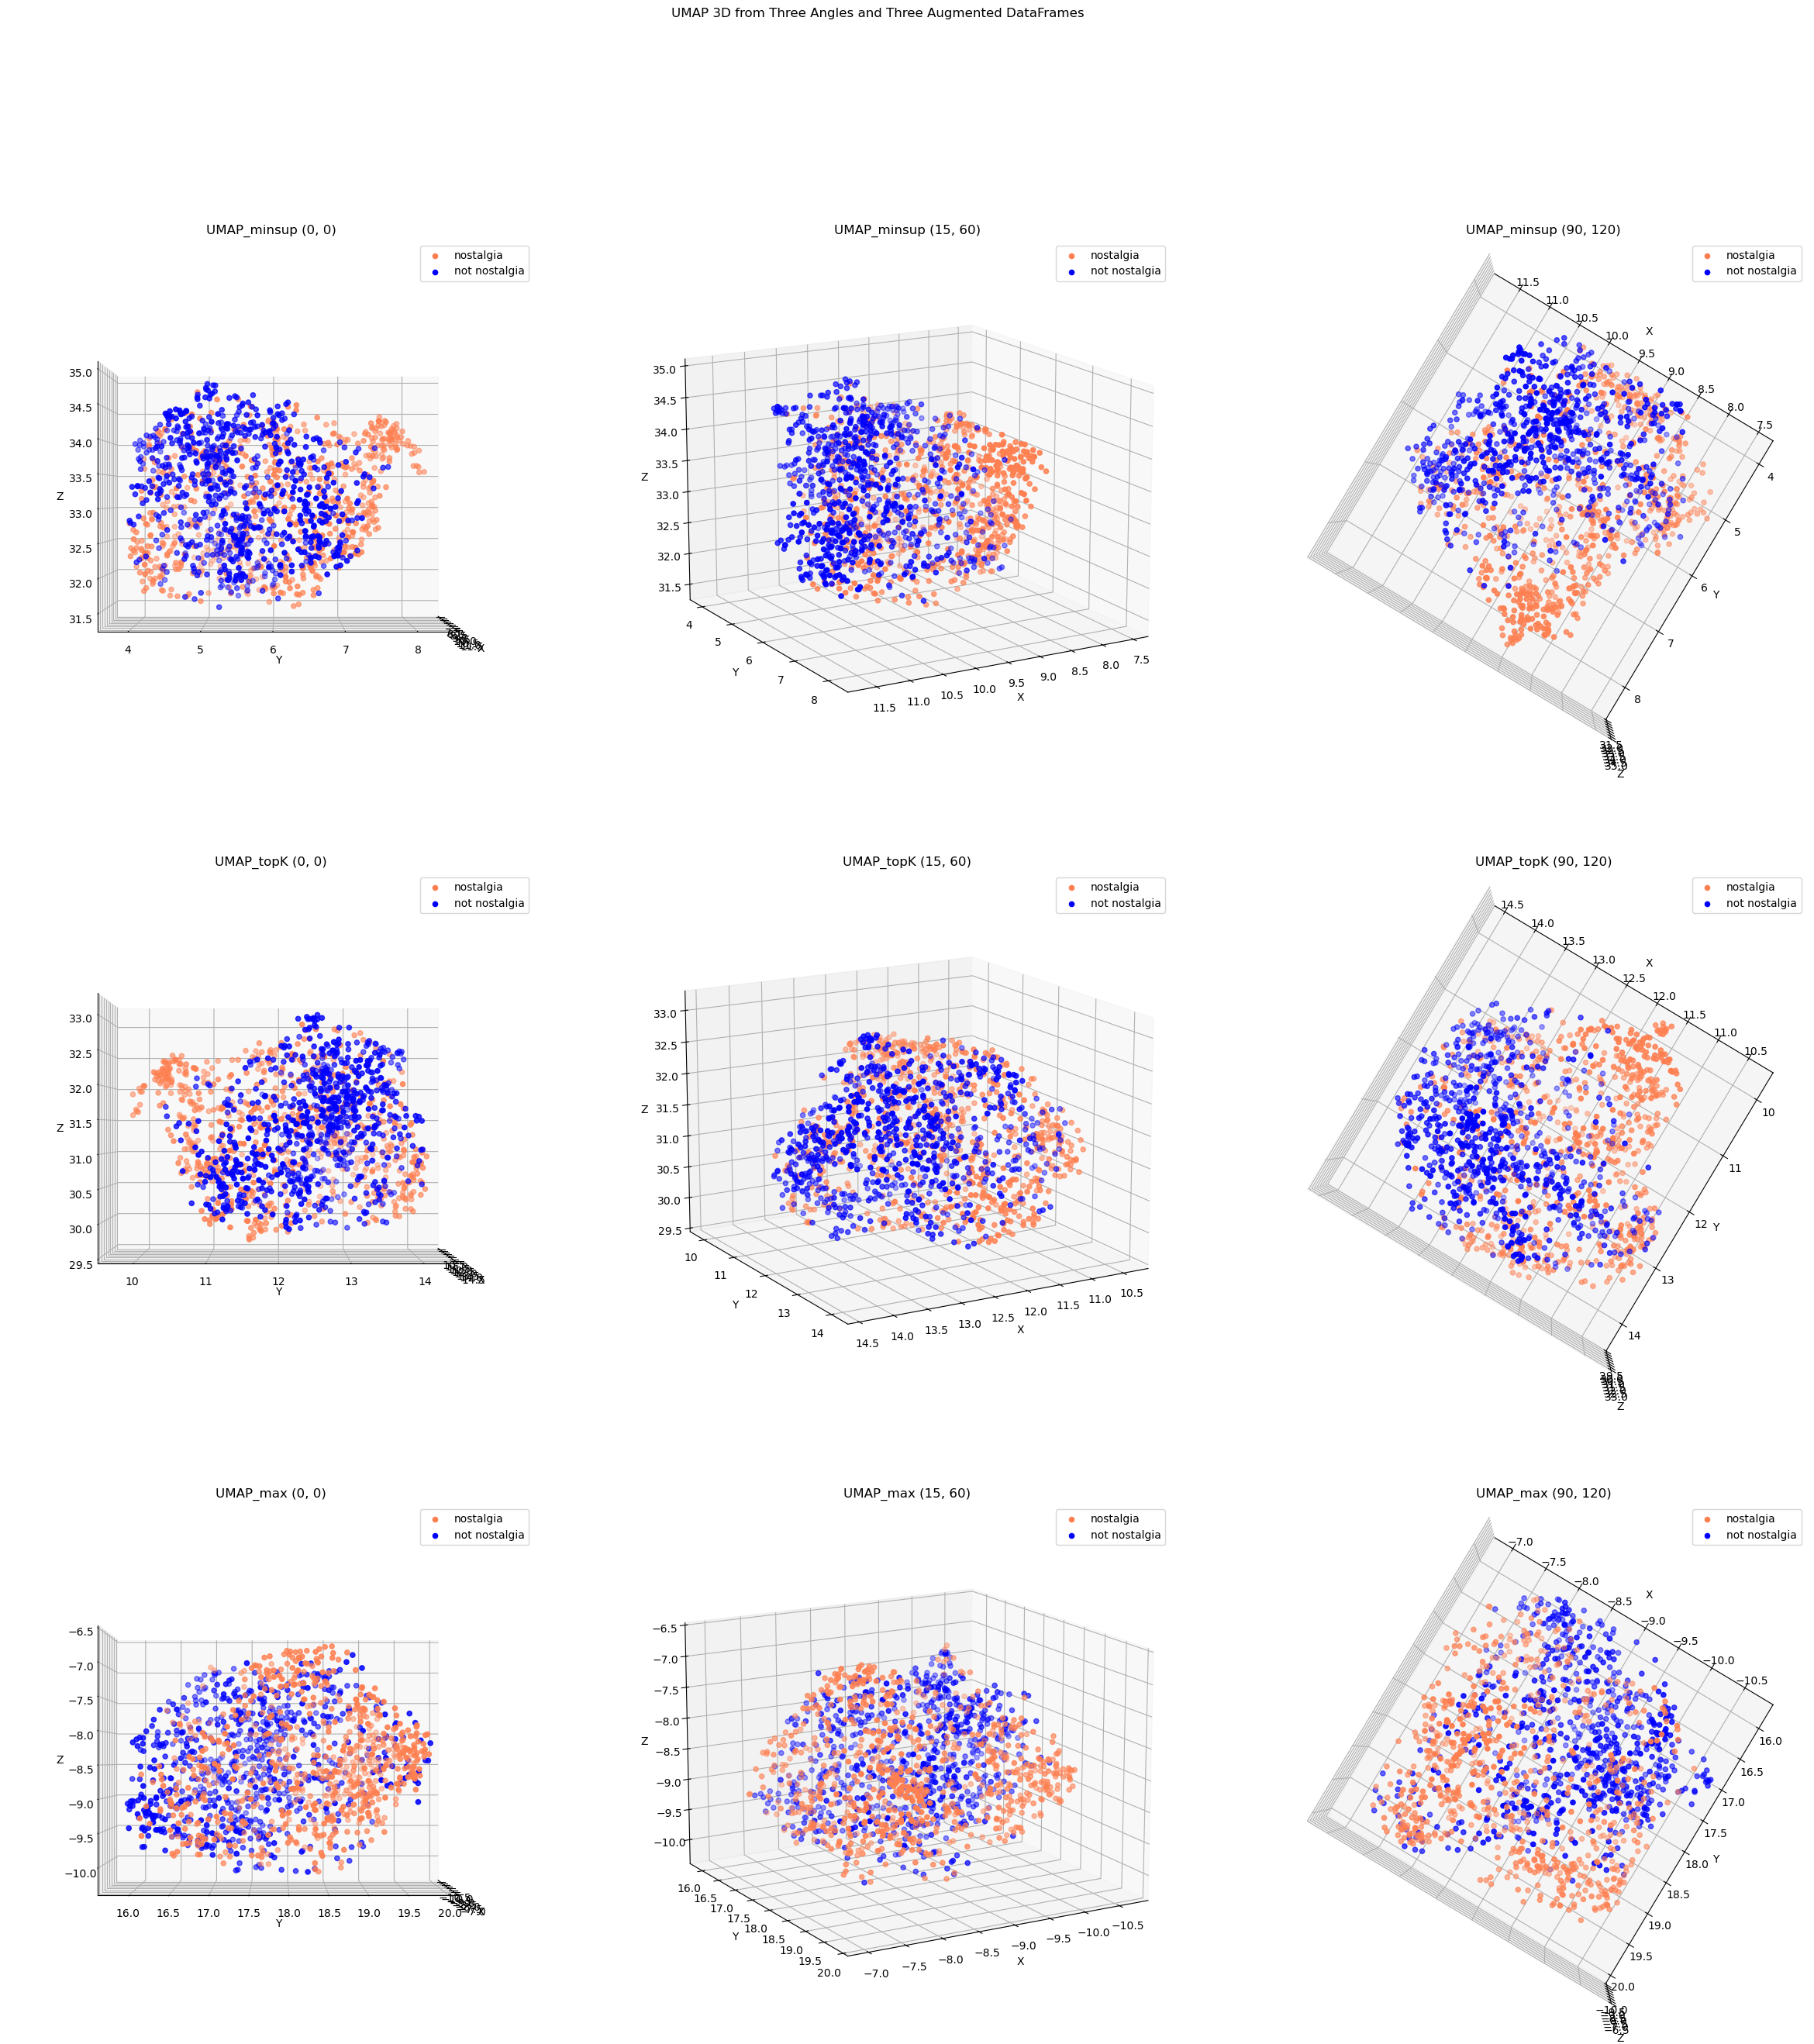

In [298]:
# 建立模型三維圖片(UMAP)
plt.close()
fig = plt.figure(figsize=(30, 30))  # 創建一個大圖形以容納九個子圖
fig.suptitle('UMAP 3D from Three Angles and Three Augmented DataFrames')

# 第一組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 1 + i, projection='3d')  # 3行3列
    plot_scatter_3d(ax, X_umap_minsup, f'UMAP_minsup ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角

# 第二組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 4 + i, projection='3d')  # 3行3列，接下來的3個子圖
    plot_scatter_3d(ax, X_umap_topK, f'UMAP_topK ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角

# 第三組子圖
for i in range(3):
    ax = fig.add_subplot(3, 3, 7 + i, projection='3d')  # 3行3列，最後的3個子圖
    plot_scatter_3d(ax, X_umap_max, f'UMAP_max ({angle_3D[0][i]}, {angle_3D[1][i]})')
    ax.view_init(angle_3D[0][i], angle_3D[1][i])  # 設定視角
plt.show()

在第一行的圖表表明的是FPGrowth與Supmin=3的情況，在PCA與t-SNE看不太出來他們的分類，UMAP的圖形可以比較看的出來，藍色分布一邊，橘色分布一邊

在第二行的圖表表明的是FEA top 800的情況，在t-SNE是所有裡面分布最有差異的，其他都與第一行的情形差不多

在第三行的圖表表明的是MaxFPGrowth與Supmin=3的情況，在PCA依舊看不太出來他們的分類與前兩種方法差不多，而在t-SNE則是更加密集完全看不出，而在UMAP的圖形則是在第三個角度可以明顯發現兩個顏色各靠一邊

### 3.3.5 Discretization and Binarization

In [286]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy

In [287]:
mlb = preprocessing.LabelBinarizer()

In [288]:
mlb.fit(X.sentiment)

LabelBinarizer()

In [289]:
X['bin_sentiment'] = mlb.transform(X['sentiment']).tolist()

In [290]:
X[0:9]

sentiment                                            comment  \
0          1  He was a singer with a golden voice that I lov...   
1          0  The mist beautiful voice ever I listened to hi...   
2          0  I have most of Mr. Reeves songs.  Always love ...   
3          1  30 day leave from 1st tour in Viet Nam to conv...   
4          0  listening to his songs reminds me of my mum wh...   
5          0  Every time I heard this song as a child, I use...   
6          0  My dad loved listening to Jim Reeves, when I w...   
7          0  i HAVE ALSO LISTENED TO Jim Reeves since child...   
8          1           Wherever you  are you always in my heart   

  sentiment_name                                           unigrams  \
0  not nostalgia  [He, was, a, singer, with, a, golden, voice, t...   
1      nostalgia  [The, mist, beautiful, voice, ever, I, listene...   
2      nostalgia  [I, have, most, of, Mr., Reeves, songs, ., Alw...   
3  not nostalgia  [30, day, leave, from, 1st, tour, in, Viet, Na...   
4      nostalgia  [listening, to, his, songs, reminds, me, of, m...   
5      nostalgia  [Every, time, I, heard, this, song, as, a, chi...   
6      nostalgia  [My, dad, loved, listening, to, Jim, Reeves, ,...   
7      nostalgia  [i, HAVE, ALSO, LISTENED, TO, Jim, Reeves, sin...   
8  not nostalgia   [Wherever, you, are, you, always, in, my, heart]   

                                   tokenized_comment bin_sentiment  
0  {a, He, days, his, to, singers, vouch, Thank, ...           [1]  
1  {a, his, to, forgotten, him, angel, of, The, w...           [0]  
2  {a, forgot, my, smooth, had, his, to, just, so...           [0]  
3  {a, me", my, Lou., 30, Nam, to, greatest, serv...           [1]  
4  {songs, of, my, everyday, his, to, him, listen...           [0]  
5  {a, to, Every, RIP, funerals., song., your, of...           [0]  
6  {a, to, My, 70's, then,, changes, loved, Reeve...           [0]  
7  {a, nostalgic, his, to, 71, childhood, TO, LIS...           [0]  
8        {my, Wherever, always, heart, in, you, are}           [1]

## 3.4 TF-IDF

### 3.4.1 Feature subset selection

In [397]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [424]:
TFIDF_vect = TfidfVectorizer()
X_TFIDF = TFIDF_vect.fit_transform(X.comment)
TFIDF_terms = TFIDF_vect.get_feature_names_out()
TFIDF_df = pd.DataFrame(X_TFIDF.toarray(), columns=TFIDF_terms, index=X.index) 

In [425]:
TFIDF_df.shape

(1499, 3730)

In [426]:
# 進行目前特徵的矩陣做一些觀察
plot_x = ["term_"+str(i) for i in TFIDF_terms[0:20]]
plot_y = ["doc_"+ str(i) for i in list(X.index)[0:20]]
plot_z = X_TFIDF[0:20, 0:20].toarray() # X_counts[how many documents, how many terms]

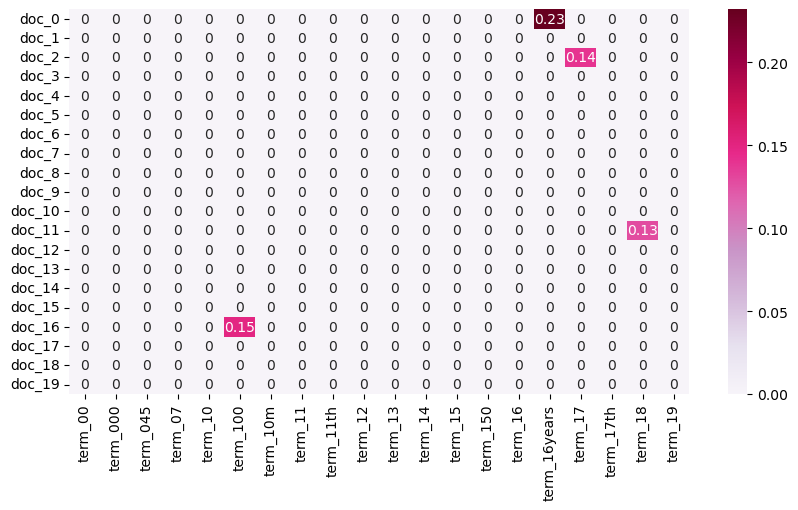

In [427]:
# 使用熱圖觀察
import seaborn as sns

df_todraw = pd.DataFrame(plot_z, columns = plot_x, index = plot_y)
plt.subplots(figsize=(10, 5))
ax = sns.heatmap(df_todraw,
                 cmap="PuRd", #熱圖的顏色映射為粉紅色調
                 vmin=0, annot=True) #annot 熱圖的每個格子中顯示數據值
plt.show()

可以看見前20個特徵在前20個文檔的可用性很低

### 3.4.2 Attribute Aggregation

#### 找出各類別的原始特徵

In [410]:
# 定義生成稀疏陣列的方程式
def create_term_document_df_TfidfVector(df,min_df=0.0,max_df=1.0):
    TFIDF_vect_temp = TfidfVectorizer(min_df=min_df, max_df=max_df) # Initialize the CountVectorizer
    X_TFIDF_temp = TFIDF_vect_temp.fit_transform(df['comment'])  # Transform the text data into word counts
    words_temp = TFIDF_vect_temp.get_feature_names_out()
    term_document_df_temp = pd.DataFrame(X_TFIDF_temp.toarray(), columns=words_temp)
    return term_document_df_temp

In [412]:
# 分別對兩個類別找屬於他們的特徵
filt_term_document_dfs = {} 
for category in categories:
    filt_term_document_dfs[category] = create_term_document_df_TfidfVector(category_dfs[category])

In [413]:
# 顯示稀疏陣列
for category in categories:
    print(f"Filtered Term-Document Frequency DataFrame for Category {category}:")
    print(filt_term_document_dfs[category])

Filtered Term-Document Frequency DataFrame for Category nostalgia:
      07   10   11  11th   12        13   14   15   16        17  ...  young  \
0    0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  ...    0.0   
1    0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.135932  ...    0.0   
2    0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  ...    0.0   
3    0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  ...    0.0   
4    0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  ...    0.0   
..   ...  ...  ...   ...  ...       ...  ...  ...  ...       ...  ...    ...   
745  0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  ...    0.0   
746  0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  ...    0.0   
747  0.0  0.0  0.0   0.0  0.0  0.225266  0.0  0.0  0.0  0.000000  ...    0.0   
748  0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  ...    0.0   
749  0.0  0.0  0.0   0.0  0.0  0.000000  0.0  0.0  0.

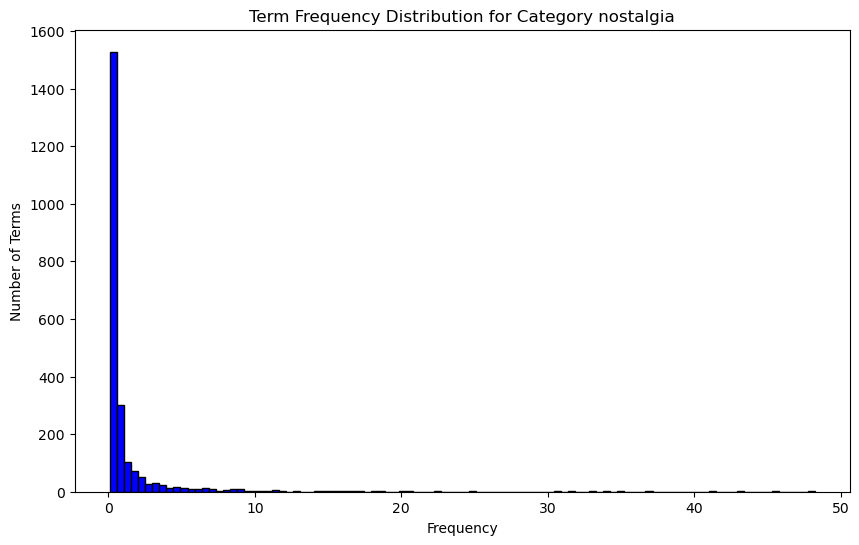

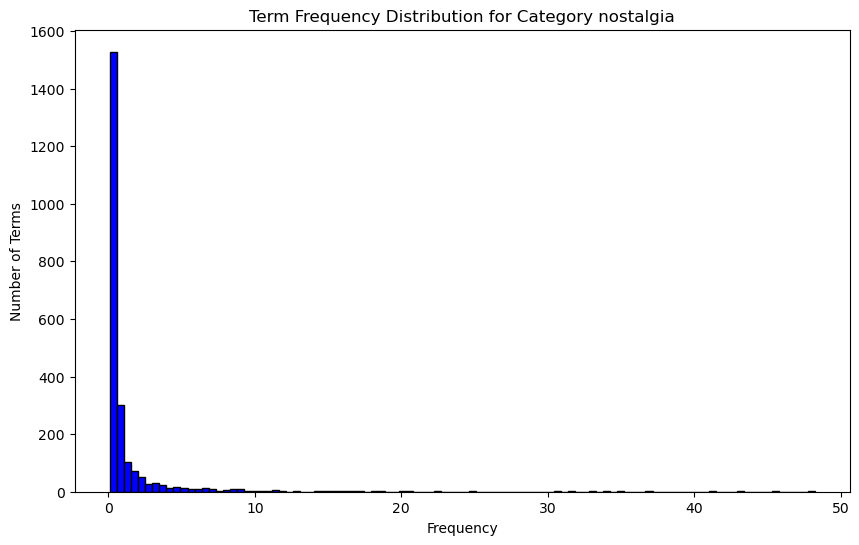

In [417]:
for category in categories:
    word_counts = filt_term_document_dfs[categories[category_number]].sum(axis=0).to_numpy()
    plt.close()
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=100,color='blue', edgecolor='black')
    plt.title(f'Term Frequency Distribution for Category {categories[category_number]}')
    plt.xlabel('Frequency')
    plt.ylabel('Number of Terms')
    plt.show()

### gpt

In [480]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
import pandas as pd

# 計算 TF-IDF 特徵
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X.comment)

# 設定方差門檻 (例如保留方差大於 0.01 的特徵)
selector = VarianceThreshold(threshold=0.001)
X_selected = selector.fit_transform(X_tfidf.toarray())

# 查看篩選後的特徵名稱
selected_features = vectorizer.get_feature_names_out()[selector.get_support()]
# print("保留的特徵:", selected_features)
from scipy.sparse import hstack

X_combined = hstack([X_selected, X_tfidf]).toarray()
X_combined

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# 4. Data Exploration

In [291]:
# We retrieve 3 sentences for a random record
document_to_transform_1 = []
random_record_1 = X.iloc[50]
random_record_1 = random_record_1['comment']
document_to_transform_1.append(random_record_1)

document_to_transform_2 = []
random_record_2 = X.iloc[100]
random_record_2 = random_record_2['comment']
document_to_transform_2.append(random_record_2)

document_to_transform_3 = []
random_record_3 = X.iloc[150]
random_record_3 = random_record_3['comment']
document_to_transform_3.append(random_record_3)

In [292]:
print(document_to_transform_1)
print(document_to_transform_2)
print(document_to_transform_3)

['If I remember correctly, this song came out after Mr. Reeves passed away. I was about 10 years old when the disc jockey said that the news just came over the wire that he died in a plane crash.']
['i guess most of us leave it too late before we tell someone just how much we really love them']
['my name is thomas but know by tommy and my wifes name is laura and i always sing this to her']


In [293]:
from sklearn.preprocessing import binarize

# Transform sentence with Vectorizers
document_vector_count_1 = count_vect.transform(document_to_transform_1)
document_vector_count_2 = count_vect.transform(document_to_transform_2)
document_vector_count_3 = count_vect.transform(document_to_transform_3)

# Binarize vectors to simplify: 0 for abscence, 1 for prescence
document_vector_count_1_bin = binarize(document_vector_count_1)
document_vector_count_2_bin = binarize(document_vector_count_2)
document_vector_count_3_bin = binarize(document_vector_count_3)

# print vectors
print("Let's take a look at the count vectors:")
print(document_vector_count_1.todense())
print(document_vector_count_2.todense())
print(document_vector_count_3.todense())

Let's take a look at the count vectors:
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]]


In [294]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate Cosine Similarity
cos_sim_count_1_2 = cosine_similarity(document_vector_count_1, document_vector_count_2, dense_output=True)
cos_sim_count_1_3 = cosine_similarity(document_vector_count_1, document_vector_count_3, dense_output=True)
cos_sim_count_2_3 = cosine_similarity(document_vector_count_2, document_vector_count_3, dense_output=True)

cos_sim_count_1_1 = cosine_similarity(document_vector_count_1, document_vector_count_1, dense_output=True)
cos_sim_count_2_2 = cosine_similarity(document_vector_count_2, document_vector_count_2, dense_output=True)
cos_sim_count_3_3 = cosine_similarity(document_vector_count_3, document_vector_count_3, dense_output=True)

# Print the cosine similarity values
print("Cosine Similarity using count between 1 and 2: %.4f" % cos_sim_count_1_2[0][0])
print("Cosine Similarity using count between 1 and 3: %.4f" % cos_sim_count_1_3[0][0])
print("Cosine Similarity using count between 2 and 3: %.4f" % cos_sim_count_2_3[0][0])

print("Cosine Similarity using count between 1 and 1: %.4f" % cos_sim_count_1_1[0][0])
print("Cosine Similarity using count between 2 and 2: %.4f" % cos_sim_count_2_2[0][0])
print("Cosine Similarity using count between 3 and 3: %.4f" % cos_sim_count_3_3[0][0])

Cosine Similarity using count between 1 and 2: 0.0322
Cosine Similarity using count between 1 and 3: 0.0279
Cosine Similarity using count between 2 and 3: 0.0000
Cosine Similarity using count between 1 and 1: 1.0000
Cosine Similarity using count between 2 and 2: 1.0000
Cosine Similarity using count between 3 and 3: 1.0000


# 5. Data Classification

In [368]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

category_mapping = dict(X[['sentiment', 'sentiment_name']].drop_duplicates().values)
print(category_mapping)

target_names = [category_mapping[label] for label in sorted(category_mapping.keys())]
print(target_names)

{1: 'not nostalgia', 0: 'nostalgia'}
['nostalgia', 'not nostalgia']


In [432]:
def Bernoulli_model(X_train, X_test, y_train, y_test):
    model = BernoulliNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names,digits=4)
    print("準確率:", accuracy)
    print("分類報告:\n", report)

In [433]:
def Multinomial_model(X_train, X_test, y_train, y_test):
    model = MultinomialNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names,digits=4)
    print("準確率:", accuracy)
    print("分類報告:\n", report)

In [434]:
def Gaussian_model(X_train, X_test, y_train, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=target_names,digits=4)
    print("準確率:", accuracy)
    print("分類報告:\n", report)

## 5.1 CountVectorizer

### 5.1.1 tdm_df

In [435]:
X_train, X_test, y_train, y_test = train_test_split(tdm_df, X['sentiment'], test_size=0.3, random_state=2)

In [436]:
Bernoulli_model(X_train, X_test, y_train, y_test)

準確率: 0.8866666666666667
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.8756    0.8955    0.8854       220
not nostalgia     0.8978    0.8783    0.8879       230

     accuracy                         0.8867       450
    macro avg     0.8867    0.8869    0.8867       450
 weighted avg     0.8869    0.8867    0.8867       450



In [437]:
Multinomial_model(X_train, X_test, y_train, y_test)

準確率: 0.8711111111111111
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.8293    0.9273    0.8755       220
not nostalgia     0.9216    0.8174    0.8664       230

     accuracy                         0.8711       450
    macro avg     0.8754    0.8723    0.8709       450
 weighted avg     0.8764    0.8711    0.8708       450



In [438]:
Gaussian_model(X_train, X_test, y_train, y_test)

準確率: 0.6666666666666666
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.6144    0.8545    0.7148       220
not nostalgia     0.7778    0.4870    0.5989       230

     accuracy                         0.6667       450
    macro avg     0.6961    0.6708    0.6569       450
 weighted avg     0.6979    0.6667    0.6556       450



### 5.1.2 augmented_df_minsup

In [439]:
X_train, X_test, y_train, y_test = train_test_split(augmented_df_minsup, X['sentiment'], test_size=0.3, random_state=2)

In [440]:
Bernoulli_model(X_train, X_test, y_train, y_test)

準確率: 0.9044444444444445
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.9116    0.8909    0.9011       220
not nostalgia     0.8979    0.9174    0.9075       230

     accuracy                         0.9044       450
    macro avg     0.9048    0.9042    0.9043       450
 weighted avg     0.9046    0.9044    0.9044       450



In [441]:
Multinomial_model(X_train, X_test, y_train, y_test)

準確率: 0.8866666666666667
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.8477    0.9364    0.8898       220
not nostalgia     0.9324    0.8391    0.8833       230

     accuracy                         0.8867       450
    macro avg     0.8901    0.8877    0.8866       450
 weighted avg     0.8910    0.8867    0.8865       450



In [442]:
Gaussian_model(X_train, X_test, y_train, y_test)

準確率: 0.7733333333333333
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.7500    0.8045    0.7763       220
not nostalgia     0.7991    0.7435    0.7703       230

     accuracy                         0.7733       450
    macro avg     0.7745    0.7740    0.7733       450
 weighted avg     0.7751    0.7733    0.7732       450



### 5.1.3 augmented_df_topK

In [443]:
X_train, X_test, y_train, y_test = train_test_split(augmented_df_topK, X['sentiment'], test_size=0.3, random_state=2)

In [444]:
Bernoulli_model(X_train, X_test, y_train, y_test)

準確率: 0.9044444444444445
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.9078    0.8955    0.9016       220
not nostalgia     0.9013    0.9130    0.9071       230

     accuracy                         0.9044       450
    macro avg     0.9046    0.9042    0.9044       450
 weighted avg     0.9045    0.9044    0.9044       450



In [445]:
Multinomial_model(X_train, X_test, y_train, y_test)

準確率: 0.8777777777777778
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.8340    0.9364    0.8822       220
not nostalgia     0.9310    0.8217    0.8730       230

     accuracy                         0.8778       450
    macro avg     0.8825    0.8791    0.8776       450
 weighted avg     0.8836    0.8778    0.8775       450



In [446]:
Gaussian_model(X_train, X_test, y_train, y_test)

準確率: 0.7111111111111111
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.6531    0.8727    0.7471       220
not nostalgia     0.8205    0.5565    0.6632       230

     accuracy                         0.7111       450
    macro avg     0.7368    0.7146    0.7051       450
 weighted avg     0.7386    0.7111    0.7042       450



### 5.1.4 augmented_df_max

In [447]:
X_train, X_test, y_train, y_test = train_test_split(augmented_df_max, X['sentiment'], test_size=0.3, random_state=2)

In [448]:
Bernoulli_model(X_train, X_test, y_train, y_test)

準確率: 0.8911111111111111
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.8977    0.8773    0.8874       220
not nostalgia     0.8851    0.9043    0.8946       230

     accuracy                         0.8911       450
    macro avg     0.8914    0.8908    0.8910       450
 weighted avg     0.8913    0.8911    0.8911       450



Multinomial_model(X_train, X_test, y_train, y_test)

In [449]:
Gaussian_model(X_train, X_test, y_train, y_test)

準確率: 0.7511111111111111
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.7030    0.8500    0.7695       220
not nostalgia     0.8207    0.6565    0.7295       230

     accuracy                         0.7511       450
    macro avg     0.7618    0.7533    0.7495       450
 weighted avg     0.7631    0.7511    0.7491       450



## 5.2 TFIDF

### 5.2.1 TFIDF_df (原始資料)

In [481]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, X['sentiment'], test_size=0.3, random_state=2)

In [482]:
Bernoulli_model(X_train, X_test, y_train, y_test)

準確率: 0.8933333333333333
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.8839    0.9000    0.8919       220
not nostalgia     0.9027    0.8870    0.8947       230

     accuracy                         0.8933       450
    macro avg     0.8933    0.8935    0.8933       450
 weighted avg     0.8935    0.8933    0.8933       450



In [483]:
Multinomial_model(X_train, X_test, y_train, y_test)

準確率: 0.8777777777777778
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.8313    0.9409    0.8827       220
not nostalgia     0.9353    0.8174    0.8724       230

     accuracy                         0.8778       450
    macro avg     0.8833    0.8792    0.8776       450
 weighted avg     0.8845    0.8778    0.8774       450



In [484]:
Gaussian_model(X_train, X_test, y_train, y_test)

準確率: 0.6733333333333333
分類報告:
                precision    recall  f1-score   support

    nostalgia     0.6272    0.8182    0.7101       220
not nostalgia     0.7546    0.5348    0.6260       230

     accuracy                         0.6733       450
    macro avg     0.6909    0.6765    0.6680       450
 weighted avg     0.6923    0.6733    0.6671       450

